In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import json
import shutil

In [2]:
# for dataset in ["essays", "wassa", "facebook"]:
#     all_files_to_copy = 0
#     for file in os.listdir(f"../Transformer_models/{dataset}_logs/"):
#         curr_files = os.listdir(f"./{dataset}_logs/")
#         if file not in curr_files:
#             shutil.copyfile(
#                 f"../Transformer_models/{dataset}_logs/{file}",
#                 f"./{dataset}_logs/{file}",
#             )
#             all_files_to_copy += 1
#     print(f"Files to copy for {dataset}: {all_files_to_copy}")

In [3]:
DATASET_TO_NAME = {
    "essays": "Personality",
    "wassa": "Empathy",
    "facebook": "Morality",
    "wassa_individual": "Empathy (non agg.)",
    "gender": "Gender",
    "cohort": "Age group",
    "party": "Affiliation",
}

BASELINES = {
    "CON": 0.5110732538330494,
    "EXT": 0.5157580919931857,
    "AGR": 0.530664395229983,
    "NEU": 0.5008517887563884,
    "OPN": 0.5161839863713799,
    ".care": 0.5070035704476792,
    ".purity": 0.5358418017028289,
    ".fairness": 0.5281516067014557,
    ".loyalty": 0.5034331227684702,
    ".authority": 0.5339192529524857,
    ".iri.concern": 0.5724331926863573,
    ".iri.distress": 0.5175808720112518,
    ".iri.fantasy": 0.5471167369901547,
    ".iri.perspective": 0.5274261603375527,
    "gender": 0.5,
    "cohort": 0.25,
    "party": 0.5,
}


FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES = {
    0: 3,
    1: 1,
    2: 0,
    3: 2,
}


DATASET_TO_BASELINES = {
    "essays": np.mean([BASELINES[x] for x in ["CON", "EXT", "AGR", "NEU", "OPN"]]),
    "wassa": np.mean(
        [
            BASELINES[x]
            for x in [
                ".iri.concern",
                ".iri.distress",
                ".iri.fantasy",
                ".iri.perspective",
            ]
        ]
    ),
    "wassa_individual": np.mean(
        [
            BASELINES[x]
            for x in [
                ".iri.concern",
                ".iri.distress",
                ".iri.fantasy",
                ".iri.perspective",
            ]
        ]
    ),
    "facebook": np.mean(
        [
            BASELINES[x]
            for x in [".care", ".purity", ".fairness", ".loyalty", ".authority"]
        ]
    ),
    "party": BASELINES["party"],
    "gender": BASELINES["gender"],
    "cohort": BASELINES["cohort"],
}

REWRITTEN_TYPE_TO_SHORT = {
    "syntax_grammar": "SG",
    "rephrase": "R",
}

LLM_TO_NAME = {
    "original": "Original",
    "gpt": "GPT3.5",
    "llama": "Llama 3",
    "gemini": "Gemini",
}

LABELS_TO_NAME = {
    ".iri.concern": "Concern",
    ".iri.distress": "Distress",
    ".iri.perspective": "Perspective",
    ".iri.fantasy": "Fantasy",
    ".authority": "Authority",
    ".care": "Care",
    ".fairness": "Fairness",
    ".loyalty": "Loyalty",
    ".purity": "Purity",
    "CON": "CON",
    "NEU": "NEU",
    "EXT": "EXT",
    "AGR": "AGR",
    "OPN": "OPN",
    "gender": "Gender",
    "cohort": "Age group",
    "party": "Party",
}

In [4]:
import matplotlib.patches as mpatches


def survey(ax, results, category_names, index):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ["darkgrey", "teal", "salmon"]

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    patches_to_return = None

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths

        widths_indices_non_zero = np.where(widths > 0)
        new_starts = starts[widths_indices_non_zero]
        new_widths = np.round(widths[widths_indices_non_zero], 1)
        new_labels = np.array(labels)[widths_indices_non_zero]
        rects = ax.barh(
            new_labels,
            new_widths,
            left=new_starts,
            height=0.6,
            label=colname,
            color=color,
        )

        r, g, b, _ = matplotlib.colors.to_rgba(color)
        text_color = "white" if r * g * b < 0.5 else "darkgrey"
        ax.bar_label(rects, label_type="center", color=text_color)
    if index == 1:
        patches = [
            mpatches.Patch(color=color, label=label)
            for label, color in zip(category_names, category_colors)
        ]
        # ax.legend(
        patches_to_return = patches
        #     bbox_to_anchor=(0.1, -0.15),
        #     loc="lower left",
        #     ncol=len(category_names),
        #     fontsize="small",
        # )

    return patches_to_return

In [5]:
def parse_file(file):
    pattern = re.compile(
        "LLM_model=(.*?)_label_column=(.*?)_model_type=(.*?)_features=(.*?)_output_type=(.*?)_reverse=(.*?)_rewritten_type=(.*?)_random_seed=(.*?).log"
    )
    extracted_pars = pattern.findall(file)
    llm_model = extracted_pars[0][0]
    label = extracted_pars[0][1]
    model_type = extracted_pars[0][2]
    feature = extracted_pars[0][3]
    output_type = extracted_pars[0][4]
    reversed = int(extracted_pars[0][5])
    rewritten_type = extracted_pars[0][6]
    random_seed = str(extracted_pars[0][7])

    return (
        llm_model,
        label,
        model_type,
        feature,
        output_type,
        reversed,
        rewritten_type,
        random_seed,
    )

In [6]:
def read_data():
    full_names = []
    datasets = []
    LLM_models = []
    label_columns = []
    model_types = []
    features = []
    output_types = []
    reverses = []
    rewritten_types = []
    random_seeds = []
    best_results = []
    best_results_on_test = []
    best_results_on_rewritten = []

    for dataset in ["essays", "wassa", "facebook", "political"]:
        directory = f"{dataset}_logs"
        print("length of directory: ", len(os.listdir(directory)))

        for file in os.listdir(directory):

            if not file.endswith(".log") or not "random_seed" in file:
                continue
            with open(os.path.join(directory, file)) as f:
                data = f.readlines()

            (
                llm_model,
                label,
                model_type,
                feature,
                output_type,
                reversed,
                rewritten_type,
                random_seed,
            ) = parse_file(file)

            best_results_found = False
            best_results_on_test_found = False
            best_results_rewritten_found = False

            best_results_index = None
            best_results_on_test_index = None
            best_results_on_rewritten_index = None

            try:
                for index, line in enumerate(data):
                    if line.startswith("best score:"):
                        best_results_index = float(data[index + 1].strip())
                        best_results_found = True
                    if line.startswith("best score on test essays"):
                        best_results_on_test_index = float(data[index + 1].strip())
                        best_results_on_test_found = True
                    if line.startswith("best score on rewritten essays"):
                        best_results_on_rewritten_index = float(data[index + 1].strip())
                        best_results_rewritten_found = True

            except Exception as e:
                print(e)
                print(file)
                return

            if best_results_rewritten_found == False:
                if reversed == 2:
                    best_results_on_rewritten_index = np.nan
                else:
                    print("error")
                    print(file)
                    continue
            if best_results_on_test_found == False or best_results_found == False:
                print("error")
                print(file)

                continue

            best_results.append(best_results_index)
            best_results_on_test.append(best_results_on_test_index)
            best_results_on_rewritten.append(best_results_on_rewritten_index)
            datasets.append(dataset)
            LLM_models.append(llm_model)
            label_columns.append(label)
            model_types.append(model_type)
            features.append(feature)
            output_types.append(output_type)
            reverses.append(reversed)
            rewritten_types.append(rewritten_type)
            random_seeds.append(random_seed)
            full_names.append(file)

    df = pd.DataFrame(
        {
            "file_name": full_names,
            "dataset": datasets,
            "LLM_model": LLM_models,
            "label": label_columns,
            "model_type": model_types,
            "feature": features,
            "output_type": output_types,
            "reverse": reverses,
            "rewritten_type": rewritten_types,
            "random_seed": random_seeds,
            "best_results": best_results,
            "best_results_on_test": best_results_on_test,
            "best_results_on_rewritten": best_results_on_rewritten,
        }
    )

    df = df[df["output_type"] == "classification"]
    df = df.drop(columns=["output_type"], axis=1)

    df["rewritten_type_str"] = df["rewritten_type"]
    df["rewritten_type"] = df["rewritten_type"].replace(
        {
            "syntax_grammar_llama_cleaned": "syntax_grammar",
            "rephrase_llama_cleaned": "rephrase",
            "syntax_grammar_llama": "syntax_grammar",
            "syntax_grammar_gemini_cleaned": "syntax_grammar",
            "rephrase_gpt": "rephrase",
            "rephrase_gemini_cleaned": "rephrase",
            "rephrase_gemini": "rephrase",
            "syntax_grammar_gpt": "syntax_grammar",
            "rephrase_llama": "rephrase",
            "syntax_grammar_gemini": "syntax_grammar",
        }
    )

    df["baseline"] = df["label"].map(BASELINES)

    def filter_good_df(row):
        if row["best_results_on_test"] > row["baseline"]:
            return True
        return False

    df["good_row"] = df.apply(filter_good_df, axis=1)

    # print(df.shape)
    # df = df[df["good_row"] == True]
    df["dataset"] = df.apply(
        lambda row: (row["dataset"] if row["dataset"] != "political" else row["label"]),
        axis=1,
    )
    # df.drop(columns=["good_row"], inplace=True)

    print(df.shape)

    return df

In [7]:
df = read_data()
df.head()

length of directory:  28519
length of directory:  88952
length of directory:  19677
length of directory:  22801
(91382, 15)


,file_name,dataset,LLM_model,label,model_type,feature,reverse,rewritten_type,random_seed,best_results,best_results_on_test,best_results_on_rewritten,rewritten_type_str,baseline,good_row
0,LLM_model=gemini_label_column=CON_model_type=g...,essays,gemini,CON,gradient_boosting,tfidf,0,rephrase,1707986649,0.660399,0.657407,0.657895,rephrase_gemini,0.511073,True
1,LLM_model=llama_label_column=CON_model_type=gr...,essays,llama,CON,gradient_boosting,openai,0,rephrase,88428879,0.800304,0.555079,0.694429,rephrase,0.511073,True
2,LLM_model=llama_label_column=OPN_model_type=sv...,essays,llama,OPN,svm,openai,0,rephrase,87300891,0.797042,0.293799,0.841163,rephrase,0.516184,False
3,LLM_model=gpt_label_column=NEU_model_type=long...,essays,gpt,NEU,longformer,longformer,0,rephrase,25887116,0.772466,0.402757,0.588969,rephrase,0.500852,False
4,LLM_model=gemini_label_column=NEU_model_type=s...,essays,gemini,NEU,svm,openai,0,syntax_grammar,34330512,0.402867,0.932297,0.486554,syntax_grammar,0.500852,True


In [8]:
df[["dataset", "label"]].drop_duplicates()

,dataset,label
0,essays,CON
2,essays,OPN
3,essays,NEU
11,essays,AGR
14,essays,EXT
16651,wassa,.iri.concern
16652,wassa,.iri.perspective
16657,wassa,.iri.fantasy
16665,wassa,.iri.distress
66377,facebook,.authority


In [9]:
df[df["label"] == "EXT"].groupby(["model_type"])["best_results_on_test"].mean()

model_type
gradient_boosting    0.645528
longformer           0.554662
random_forest        0.613939
regression           0.549427
svm                  0.672760
Name: best_results_on_test, dtype: float64

In [10]:
all_ratios = (
    df[df["reverse"] == 0]
    .groupby(
        ["dataset", "LLM_model", "label", "rewritten_type", "model_type", "feature"]
    )
    .apply(
        lambda x: pd.Series(
            [
                len(x),
                np.sum(x["good_row"]),
                np.mean(x["good_row"]),
                np.mean(x["best_results"]),
                np.mean(x["best_results_on_test"]),
                np.mean(x["best_results_on_rewritten"]),
                np.std(x["best_results"]),
                np.std(x["best_results_on_test"]),
                np.std(x["best_results_on_rewritten"]),
            ],
            index=[
                "all_counts",
                "count",
                "ratio",
                "best_results",
                "best_results_on_test",
                "best_results_on_rewritten",
                "std_best_results",
                "std_best_results_on_test",
                "std_best_results_on_rewritten",
            ],
        )
    )
)

all_ratios = all_ratios[all_ratios["count"] != 0]
all_ratios[(all_ratios["ratio"] > 0.1) & (all_ratios["count"] > 20)]

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3564593618.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


all_counts  \
dataset LLM_model label            rewritten_type model_type        feature               
cohort  gemini    cohort           rephrase       gradient_boosting tfidf          41.0   
                                                  regression        tfidf          21.0   
                                                  svm               openai         21.0   
                                                                    tfidf          41.0   
                                   syntax_grammar gradient_boosting openai         42.0   
...                                                                                 ...   
wassa   llama     .iri.perspective syntax_grammar random_forest     tfidf          78.0   
                                                  regression        openai         78.0   
                                                                    tfidf          78.0   
                                                  svm               openai         78.0   
                                                                    tfidf          78.0   

                                                                             count  \
dataset LLM_model label            rewritten_type model_type        feature          
cohort  gemini    cohort           rephrase       gradient_boosting tfidf     24.0   
                                                  regression        tfidf     21.0   
                                                  svm               openai    21.0   
                                                                    tfidf     25.0   
                                   syntax_grammar gradient_boosting openai    22.0   
...                                                                            ...   
wassa   llama     .iri.perspective syntax_grammar random_forest     tfidf     50.0   
                                                  regression        openai    41.0   
                                                                    tfidf     62.0   
                                                  svm               openai    50.0   
                                                                    tfidf     59.0   

                                                                                ratio  \
dataset LLM_model label            rewritten_type model_type        feature             
cohort  gemini    cohort           rephrase       gradient_boosting tfidf    0.585366   
                                                  regression        tfidf    1.000000   
                                                  svm               openai   1.000000   
                                                                    tfidf    0.609756   
                                   syntax_grammar gradient_boosting openai   0.523810   
...                                                                               ...   
wassa   llama     .iri.perspective syntax_grammar random_forest     tfidf    0.641026   
                                                  regression        openai   0.525641   
                                                                    tfidf    0.794872   
                                                  svm               openai   0.641026   
                                                                    tfidf    0.756410   

                                                                             best_results  \
dataset LLM_model label            rewritten_type model_type        feature                 
cohort  gemini    cohort           rephrase       gradient_boosting tfidf        0.297061   
                                                  regression        tfidf        0.305883   
                                                  svm               openai       0.295320   
                                                                    tfidf        0.256126   
                                   syntax_grammar gradient

In [11]:
all_ratios["all_counts"].describe()

count    874.000000
mean      43.124714
std       19.932860
min       20.000000
25%       32.250000
50%       36.000000
75%       41.000000
max       98.000000
Name: all_counts, dtype: float64

In [12]:
bad_indices = []
for index in all_ratios[(all_ratios["count"] < 20) | (all_ratios["ratio"] < 0.1)].index:
    bad_indices.extend(
        df[
            (df["dataset"] == index[0])
            & (df["LLM_model"] == index[1])
            & (df["label"] == index[2])
            & (df["rewritten_type"] == index[3])
            & (df["model_type"] == index[4])
            & (df["feature"] == index[5])
        ].index.tolist()
    )
print(df.shape)
df = df.drop(bad_indices)
print(df.shape)

(91382, 15)
(79028, 15)


In [13]:
print(df.shape)
df = df[df["good_row"] == True]
print(df.shape)

(79028, 15)
(51971, 15)


In [14]:
sum(
    df[df["reverse"] == 0]
    .groupby(
        ["dataset", "LLM_model", "label", "rewritten_type", "model_type", "feature"]
    )
    .apply(lambda x: len(x))
    < 20
)

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/480634538.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: len(x))


0

In [15]:
df.to_csv("all_runs.csv", index=False)

In [16]:
final_paper_df = df[df["reverse"] == 0].copy()

In [17]:
# in final_paper_df[final_paper_df["label"] == "party"], compare the best_results_on_test and best_results_on_rewritten using a t-test
# and also provide all the statistics like the confidence interval, mean, std, etc.

from scipy.stats import ttest_rel

tests_values = final_paper_df[final_paper_df["label"] == "party"][
    "best_results_on_test"
]
rewritten_values = final_paper_df[final_paper_df["label"] == "party"][
    "best_results_on_rewritten"
]

stats, p = ttest_rel(tests_values, rewritten_values)
# print all these \text{Trait}  & Mean $F_{1OG}$ & $\text{Mean $F_1$}_{\text{LLM}}$ & $\Delta_{\text{Mean } F_1 }$& 95\% CI & SE & \emph{t} & df & \emph{p} & \emph{d} & \emph{N}

print("Mean test: ", np.mean(tests_values))
print("Mean rewritten: ", np.mean(rewritten_values))
print("Mean difference: ", np.mean(tests_values) - np.mean(rewritten_values))

Mean test:  0.6635982850046719
Mean rewritten:  0.5908854465656177
Mean difference:  0.07271283843905418


## difference between LLMs

In [18]:
final_paper_df = df[df["reverse"] == 0].copy()

In [19]:
df_grouped_by_dataset_llm_model = (
    df.groupby(["dataset", "LLM_model"])
    .apply(
        lambda x: pd.Series(
            {
                "original": np.mean(x["best_results_on_test"]),
                "rewritten": np.mean(x["best_results_on_rewritten"]),
            }
        )
    )
    .reset_index()
)
df_grouped_by_dataset_llm_model

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3156234667.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,dataset,LLM_model,original,rewritten
0,cohort,gemini,0.310214,0.274799
1,cohort,gpt,0.325731,0.290602
2,cohort,llama,0.321175,0.266165
3,essays,gemini,0.653480,0.599136
4,essays,gpt,0.617916,0.605338
5,essays,llama,0.643917,0.600298
6,facebook,gemini,0.620125,0.573215
7,facebook,gpt,0.615987,0.583086
8,facebook,llama,0.627426,0.569590
9,gender,gemini,0.656366,0.630171


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1201238601.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1201238601.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1201238601.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1201238601.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

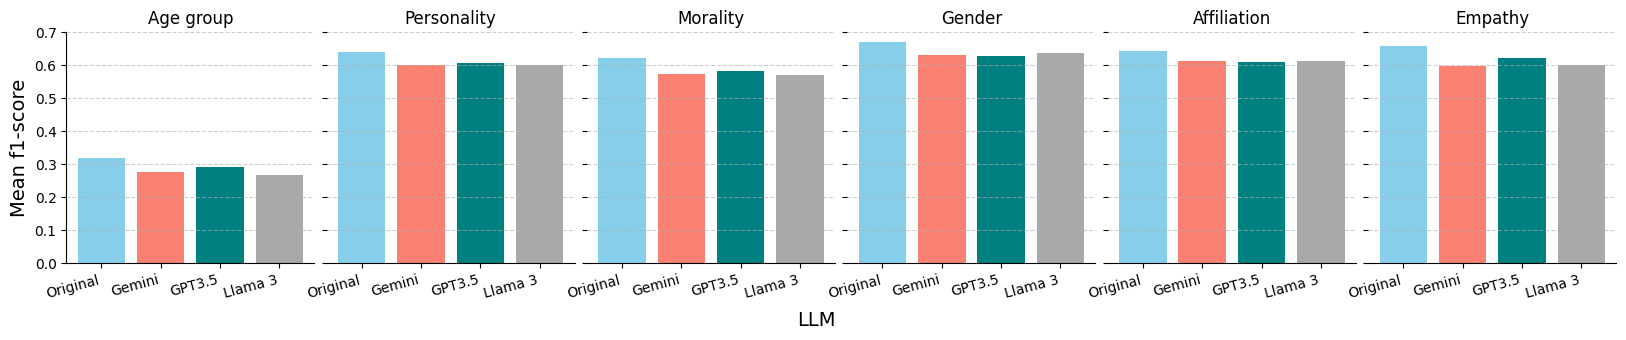

In [20]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3))

for ax_index, (dataset, ax) in enumerate(
    zip(df_grouped_by_dataset_llm_model["dataset"].unique(), axs)
):
    data = df_grouped_by_dataset_llm_model[
        df_grouped_by_dataset_llm_model["dataset"] == dataset
    ]
    original_values = data["original"].mean()
    rewritten_values = {
        LLM_TO_NAME[llm_model]: data[data["LLM_model"] == llm_model]["rewritten"].mean()
        for llm_model in data["LLM_model"].unique()
    }
    all_values = {
        "Original": original_values,
        **rewritten_values,
    }
    ax.bar(
        all_values.keys(),
        all_values.values(),
        color=["skyblue", "salmon", "teal", "darkgrey"],
    )
    ax.set_title(DATASET_TO_NAME[dataset])

    # for all ax_index except for the first one, drop the y axis
    if ax_index != 0:
        # remove the y tick labels
        ax.set_yticklabels([])
        # drop the left spine
        ax.spines[["left"]].set_visible(False)
    else:
        ax.set_ylabel("Mean f1-score", fontsize=14)
    # for x tick labels make them tilted with 20 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    ax.set_ylim(0.0, 0.7)

    # drop the top and right spines
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# fig x label should be LLM
fig.text(0.5, -0.1, "LLM", ha="center", fontsize=14)
plt.savefig("difference_between_llms.png", bbox_inches="tight", dpi=300)
plt.show()

## difference between prompts

In [21]:
df_grouped_by_dataset_llm_model = (
    df.groupby(["dataset", "rewritten_type"])
    .apply(
        lambda x: pd.Series(
            {
                "original": np.mean(x["best_results_on_test"]),
                "rewritten": np.mean(x["best_results_on_rewritten"]),
            }
        )
    )
    .reset_index()
)
df_grouped_by_dataset_llm_model

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/2592224549.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,dataset,rewritten_type,original,rewritten
0,cohort,rephrase,0.320027,0.272578
1,cohort,syntax_grammar,0.317521,0.280888
2,essays,rephrase,0.636804,0.600573
3,essays,syntax_grammar,0.632571,0.603944
4,facebook,rephrase,0.622485,0.573056
5,facebook,syntax_grammar,0.618749,0.578985
6,gender,rephrase,0.667082,0.617174
7,gender,syntax_grammar,0.670802,0.644063
8,party,rephrase,0.640380,0.602945
9,party,syntax_grammar,0.643881,0.618216


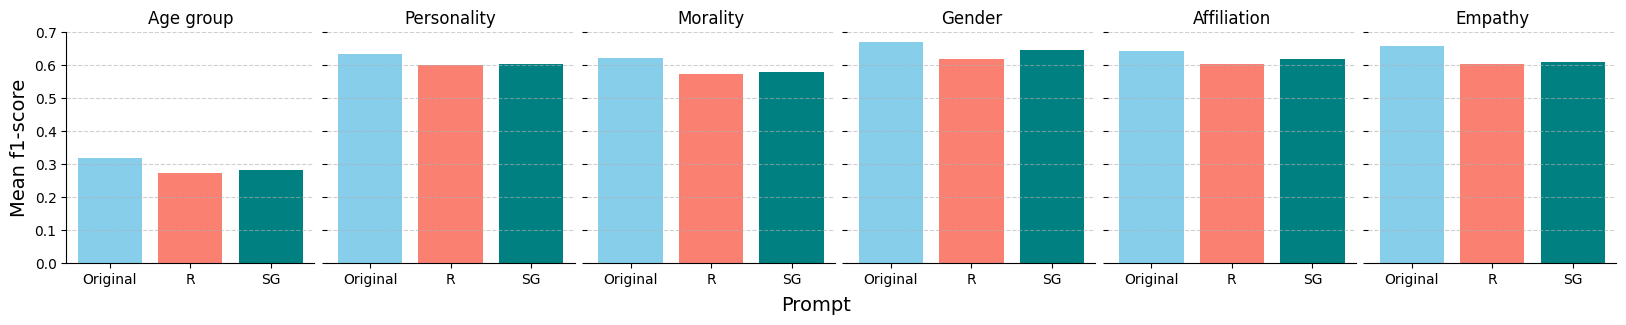

In [22]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3))

for ax_index, (dataset, ax) in enumerate(
    zip(df_grouped_by_dataset_llm_model["dataset"].unique(), axs)
):
    data = df_grouped_by_dataset_llm_model[
        df_grouped_by_dataset_llm_model["dataset"] == dataset
    ]
    original_values = data["original"].mean()
    rewritten_values = {
        REWRITTEN_TYPE_TO_SHORT[llm_model]: data[data["rewritten_type"] == llm_model][
            "rewritten"
        ].mean()
        for llm_model in data["rewritten_type"].unique()
    }
    all_values = {
        "Original": original_values,
        **rewritten_values,
    }
    ax.bar(
        all_values.keys(),
        all_values.values(),
        color=["skyblue", "salmon", "teal"],
    )
    ax.set_title(DATASET_TO_NAME[dataset])

    # for all ax_index except for the first one, drop the y axis
    if ax_index != 0:
        # remove the y tick labels
        ax.set_yticklabels([])
        # drop the left spine
        ax.spines[["left"]].set_visible(False)
    else:
        ax.set_ylabel("Mean f1-score", fontsize=14)
    # for x tick labels make them tilted with 20 degrees
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    ax.set_ylim(0.0, 0.7)

    # drop the top and right spines
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# fig x label should be LLM
fig.text(0.5, -0.05, "Prompt", ha="center", fontsize=14)
plt.savefig("difference_between_prompts.png", bbox_inches="tight", dpi=300)
plt.show()

## difference between model_types

In [23]:
df_grouped_by_dataset_llm_model = (
    df.groupby(["dataset", "model_type"])
    .apply(
        lambda x: pd.Series(
            {
                "original": np.mean(x["best_results_on_test"]),
                "rewritten": np.mean(x["best_results_on_rewritten"]),
            }
        )
    )
    .reset_index()
)
df_grouped_by_dataset_llm_model

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1263440265.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,dataset,model_type,original,rewritten
0,cohort,gradient_boosting,0.308243,0.252590
1,cohort,longformer,0.275251,0.161888
2,cohort,regression,0.325068,0.292284
3,cohort,svm,0.317865,0.274772
4,essays,gradient_boosting,0.668701,0.618801
5,essays,longformer,0.661880,0.579803
6,essays,random_forest,0.627607,0.594484
7,essays,regression,0.571028,0.540700
8,essays,svm,0.669183,0.650051
9,facebook,gradient_boosting,0.614306,0.567106


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/847612684.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/847612684.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/847612684.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/847612684.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

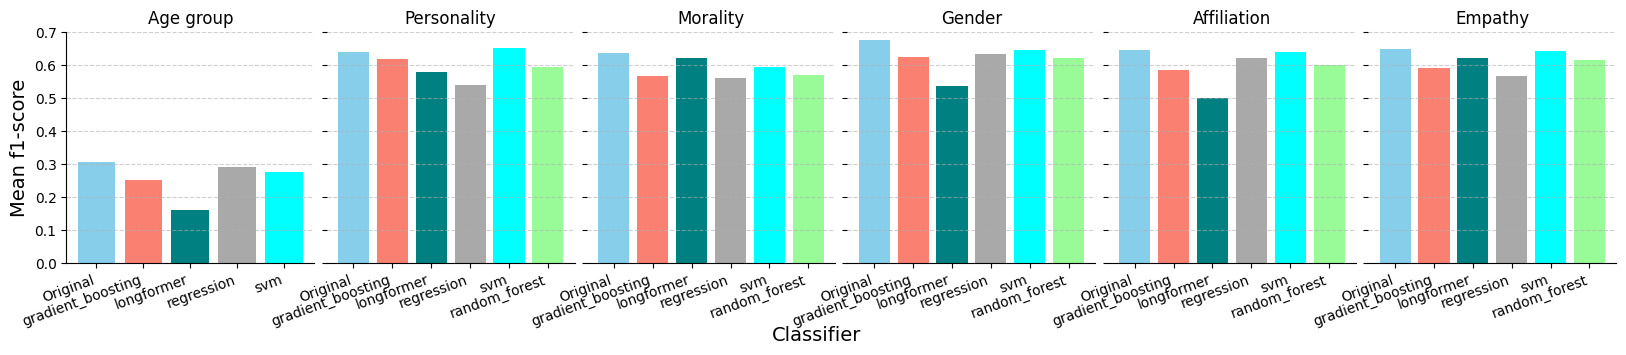

In [24]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3))

for ax_index, (dataset, ax) in enumerate(
    zip(df_grouped_by_dataset_llm_model["dataset"].unique(), axs)
):
    data = df_grouped_by_dataset_llm_model[
        df_grouped_by_dataset_llm_model["dataset"] == dataset
    ]
    original_values = data["original"].mean()
    rewritten_values = {
        llm_model: data[data["model_type"] == llm_model]["rewritten"].mean()
        for llm_model in df_grouped_by_dataset_llm_model["model_type"].unique()
    }
    all_values = {
        "Original": original_values,
        **rewritten_values,
    }
    ax.bar(
        all_values.keys(),
        all_values.values(),
        color=["skyblue", "salmon", "teal", "darkgrey", "aqua", "palegreen"],
    )
    ax.set_title(DATASET_TO_NAME[dataset])

    # for all ax_index except for the first one, drop the y axis
    if ax_index != 0:
        # remove the y tick labels
        ax.set_yticklabels([])
        # drop the left spine
        ax.spines[["left"]].set_visible(False)
    else:
        ax.set_ylabel("Mean f1-score", fontsize=14)
    # for x tick labels make them tilted with 20 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

    ax.set_ylim(0.0, 0.7)

    # drop the top and right spines
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# fig x label should be LLM
fig.text(0.5, -0.15, "Classifier", ha="center", fontsize=14)

plt.savefig("figures/difference_between_classifiers.png", bbox_inches="tight", dpi=300)

plt.show()

## difference between features

In [25]:
df_grouped_by_dataset_llm_model = (
    df.groupby(["dataset", "feature"])
    .apply(
        lambda x: pd.Series(
            {
                "original": np.mean(x["best_results_on_test"]),
                "rewritten": np.mean(x["best_results_on_rewritten"]),
            }
        )
    )
    .reset_index()
)
df_grouped_by_dataset_llm_model

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/2301673745.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,dataset,feature,original,rewritten
0,cohort,longformer,0.275251,0.161888
1,cohort,openai,0.320428,0.286726
2,cohort,tfidf,0.317269,0.269046
3,essays,longformer,0.661880,0.579803
4,essays,openai,0.631892,0.605174
5,essays,tfidf,0.636462,0.600202
6,facebook,longformer,0.718728,0.620663
7,facebook,openai,0.629007,0.589165
8,facebook,tfidf,0.601229,0.555541
9,gender,longformer,0.700220,0.536004


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3533614727.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3533614727.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3533614727.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3533614727.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

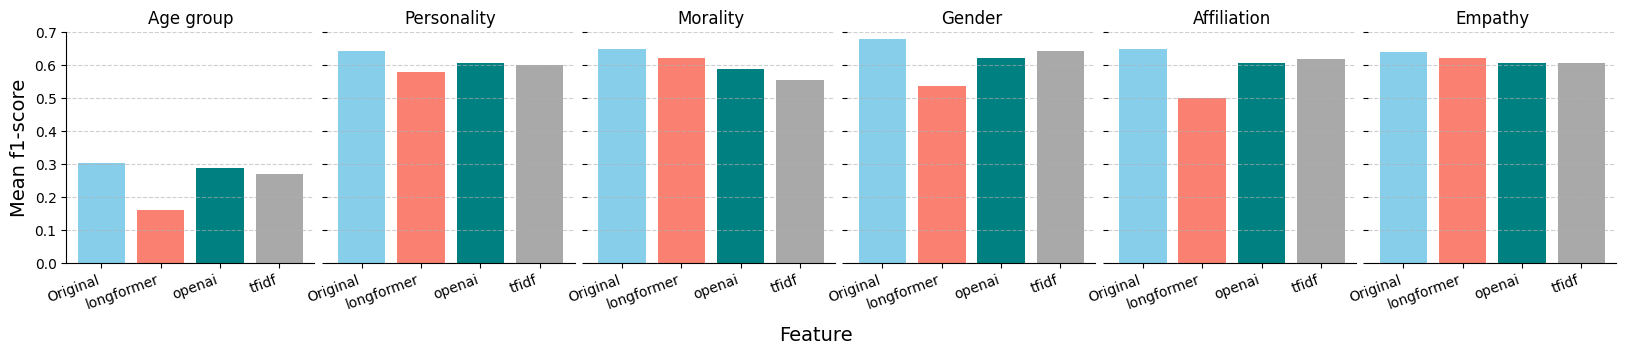

In [26]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3))

for ax_index, (dataset, ax) in enumerate(
    zip(df_grouped_by_dataset_llm_model["dataset"].unique(), axs)
):
    data = df_grouped_by_dataset_llm_model[
        df_grouped_by_dataset_llm_model["dataset"] == dataset
    ]
    original_values = data["original"].mean()
    rewritten_values = {
        llm_model: data[data["feature"] == llm_model]["rewritten"].mean()
        for llm_model in df_grouped_by_dataset_llm_model["feature"].unique()
    }
    all_values = {
        "Original": original_values,
        **rewritten_values,
    }
    ax.bar(
        all_values.keys(),
        all_values.values(),
        color=["skyblue", "salmon", "teal", "darkgrey"],
    )
    ax.set_title(DATASET_TO_NAME[dataset])

    # for all ax_index except for the first one, drop the y axis
    if ax_index != 0:
        # remove the y tick labels
        ax.set_yticklabels([])
        # drop the left spine
        ax.spines[["left"]].set_visible(False)
    else:
        ax.set_ylabel("Mean f1-score", fontsize=14)
    # for x tick labels make them tilted with 20 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

    ax.set_ylim(0.0, 0.7)

    # drop the top and right spines
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
# fig x label should be LLM
fig.text(0.5, -0.15, "Feature", ha="center", fontsize=14)

plt.savefig("figures/difference_between_features.png", bbox_inches="tight", dpi=300)

plt.show()

## statistical analysis for the difference between llms, prompts, classifiers, and featurization techniques

In [27]:
import scipy.stats as stats

final_paper_df["differences"] = (
    final_paper_df["best_results_on_test"] - final_paper_df["best_results_on_rewritten"]
) / final_paper_df["best_results_on_test"]

variables_to_focus_on = [
    "dataset",
    "LLM_model",
    "model_type",
    "feature",
    "rewritten_type",
]


for variable in variables_to_focus_on:
    all_values = []
    unique_values_for_variable = final_paper_df[variable].unique()
    if len(unique_values_for_variable) == 2:
        test_to_use = "t-test"
    else:
        test_to_use = "ANOVA"
    for value in unique_values_for_variable:
        filtered_df = (
            final_paper_df[final_paper_df[variable] == value]
            .groupby([col for col in variables_to_focus_on if col != variable])[
                "differences"
            ]
            .mean()
            .sort_index()
        )
        all_values.append(filtered_df.values)
    if test_to_use == "t-test":
        print(variable, stats.wilcoxon(*all_values, method="approx"))
        effect_size = stats.wilcoxon(*all_values, method="approx").zstatistic / np.sqrt(
            len(all_values[0])
        )
        print(
            "Effect size",
            effect_size,
        )
        if np.abs(effect_size) >= 0.5:
            print("Large effect size")
        elif np.abs(effect_size) >= 0.3:
            print("Moderate effect size")
        elif np.abs(effect_size) >= 0.1:
            print("Small effect size")
        else:
            print("Negligible effect size")

    else:
        # print(variable, stats.f_oneway(*all_values))
        print(variable, stats.kruskal(*all_values))
        effect_size = (
            stats.kruskal(*all_values).statistic - len(unique_values_for_variable) + 1
        ) / (len(all_values[0]) - len(unique_values_for_variable))
        print("Effect size: ", effect_size)
        if effect_size >= 0.14:
            print("Large effect size")
        elif 0.06 <= effect_size <= 0.14:
            print("Moderate effect size")
        else:
            print("Small effect size")

        # then do the post hoc test
        from scikit_posthocs import posthoc_dunn

        # posthoc = pairwise_tukeyhsd(
        #     final_paper_df.set_index(variables_to_focus_on).sort_index()["differences"],
        #     final_paper_df.set_index(variables_to_focus_on)
        #     .sort_index()
        #     .index.get_level_values(variable),
        #     alpha=0.05,
        # )

        posthoc = posthoc_dunn(
            all_values,
            p_adjust="bonferroni",
        )
        posthoc.index = unique_values_for_variable
        posthoc.columns = unique_values_for_variable

        print(posthoc)
    for value, value_values in zip(unique_values_for_variable, all_values):
        print(value, np.mean(value_values), np.median(value_values))

    print("-----------------")

dataset KruskalResult(statistic=41.91381237119174, pvalue=6.131753903777385e-08)
Effect size:  0.7690377577331612
Large effect size
                essays         wassa  facebook     party    gender  \
essays    1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000   
wassa     1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000   
facebook  1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000   
party     1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000   
gender    1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000   
cohort    6.430902e-07  2.768427e-07  0.000001  0.000003  0.000004   

                cohort  
essays    6.430902e-07  
wassa     2.768427e-07  
facebook  1.456626e-06  
party     3.176043e-06  
gender    4.100129e-06  
cohort    1.000000e+00  
essays 0.0784613549902353 0.07991382548220963
wassa 0.08395220011891696 0.06504233515382149
facebook 0.08061359876836749 0.07634660107761346
party 0.08851055706267008 0.07390317902404021
gender 0.083797

## level of predictive power across different dimensions of the personal traits

In [28]:
import numpy as np


def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return np.abs((u1 - u2) / s)

In [29]:
def compute_cohen_d(c0, c1):
    from statistics import mean, stdev
    from math import sqrt

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

    return np.abs(cohens_d)

In [30]:
# two random distribuitions
a = np.random.normal(0, 1, 1000)
b = np.random.normal(0.5, 1, 1000)

# calculate cohen's d
d = compute_cohen_d(a, b)
print(d)

d = cohend(a, b)
print(d)

0.513093200130515
0.5130932001305148


In [31]:
from scipy.stats import ttest_rel
import numpy as np, statsmodels.stats.api as sms


datasets = []
dimensions = []
mean_original_f1_scores = []
mean_rewritten_f1_scores = []
CI_for_comparison = []
SE_for_comparison = []
t_test_results = []
degree_of_freedom_results = []
p_values = []
cohen_ds = []
Ns = []
magnitudes = []
random_baselines = []

for dataset in final_paper_df["dataset"].unique():
    for label in final_paper_df[(final_paper_df["dataset"] == dataset)][
        "label"
    ].unique():
        filtered_data = final_paper_df[
            (final_paper_df["dataset"] == dataset) & (final_paper_df["label"] == label)
        ]
        original_values = filtered_data["best_results_on_test"].values
        rewritten_values = filtered_data["best_results_on_rewritten"].values

        stats_val, p = ttest_rel(original_values, rewritten_values)
        N = len(original_values)

        datasets.append(DATASET_TO_NAME[dataset])
        dimensions.append(LABELS_TO_NAME[label])
        mean_original_f1_scores.append(np.round(np.mean(original_values), 3))
        mean_rewritten_f1_scores.append(np.round(np.mean(rewritten_values), 3))
        t_test_results.append(np.round(stats_val, 3))
        p_values.append(p)
        degree_of_freedom_results.append(N - 1)
        cohen_d = compute_cohen_d(original_values, rewritten_values)
        cohen_ds.append(np.round(cohen_d, 3))
        Ns.append(N)
        magnitudes.append(
            "Large"
            if cohen_d > 0.8
            else (
                "Moderate"
                if cohen_d > 0.5
                else "Small" if cohen_d > 0.2 else "Negligible"
            )
        )
        SE_for_comparison.append(
            np.round(np.std(original_values - rewritten_values), 3)
        )
        cm = sms.CompareMeans(
            sms.DescrStatsW(original_values), sms.DescrStatsW(rewritten_values)
        )
        CI_for_comparison.append(
            [np.round(val, 3) for val in cm.tconfint_diff(usevar="unequal")]
        )
        random_baselines.append(np.round(filtered_data["baseline"].values[0], 3))


summary_df = pd.DataFrame(
    {
        "dataset": datasets,
        "dimension": dimensions,
        "mean_original_f1_score": mean_original_f1_scores,
        "mean_rewritten_f1_score": mean_rewritten_f1_scores,
        "CI_for_comparison": CI_for_comparison,
        "SE_for_comparison": SE_for_comparison,
        "t_test_result": t_test_results,
        "degree_of_freedom": degree_of_freedom_results,
        "p_value": p_values,
        "cohen_d": cohen_ds,
        "N": Ns,
        "magnitude": magnitudes,
        "random_baseline": random_baselines,
    }
)

print(
    summary_df.to_latex(
        index=False,
        column_format="lccccccccccc",
        float_format="%.3f",
        escape=False,
    )
)

\begin{tabular}{lccccccccccc}
\toprule
dataset & dimension & mean_original_f1_score & mean_rewritten_f1_score & CI_for_comparison & SE_for_comparison & t_test_result & degree_of_freedom & p_value & cohen_d & N & magnitude & random_baseline \\
\midrule
Personality & CON & 0.647 & 0.593 & [0.045, 0.061] & 0.159 & 13.085 & 1534 & 0.000 & 0.451 & 1535 & Small & 0.511 \\
Personality & NEU & 0.618 & 0.556 & [0.054, 0.071] & 0.162 & 14.727 & 1457 & 0.000 & 0.533 & 1458 & Moderate & 0.501 \\
Personality & OPN & 0.673 & 0.615 & [0.05, 0.065] & 0.164 & 14.438 & 1693 & 0.000 & 0.487 & 1694 & Small & 0.516 \\
Personality & EXT & 0.663 & 0.602 & [0.052, 0.07] & 0.161 & 14.797 & 1530 & 0.000 & 0.487 & 1531 & Small & 0.516 \\
Personality & AGR & 0.685 & 0.640 & [0.037, 0.055] & 0.170 & 10.224 & 1434 & 0.000 & 0.370 & 1435 & Small & 0.531 \\
Empathy & Perspective & 0.637 & 0.584 & [0.046, 0.06] & 0.138 & 18.613 & 2334 & 0.000 & 0.463 & 2335 & Small & 0.527 \\
Empathy & Fantasy & 0.659 & 0.619 & [0.034

## checking whether the LLMs wash away or leave the lexical cues

In [32]:
def get_results_with_diffs(df):
    df_to_work_on = df.copy()

    results_dataset = []
    results_model = []
    results_feature = []
    results_llm_model = []
    results_label = []
    results_rewritten_type = []
    results_tests = []
    results_tests_rewritten = []
    p_values = []

    for dataset in df_to_work_on["dataset"].unique():
        for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
            "label"
        ].unique():
            for llm_model in df_to_work_on["LLM_model"].unique():
                for rewritten_type in df_to_work_on["rewritten_type"].unique():
                    for model_type in df_to_work_on["model_type"].unique():
                        for feature in df_to_work_on["feature"].unique():
                            if (
                                feature == "longformer" and model_type != "longformer"
                            ) or (
                                model_type == "longformer" and feature != "longformer"
                            ):
                                continue
                            sub_df = df_to_work_on[
                                (df_to_work_on["dataset"] == dataset)
                                & (df_to_work_on["label"] == label)
                                & (df_to_work_on["LLM_model"] == llm_model)
                                & (df_to_work_on["rewritten_type"] == rewritten_type)
                                & (df_to_work_on["model_type"] == model_type)
                                & (df_to_work_on["feature"] == feature)
                                & (df_to_work_on["reverse"] == 0)
                            ].copy()

                            results_dataset.append(dataset)
                            results_label.append(label)
                            results_llm_model.append(llm_model)
                            results_rewritten_type.append(rewritten_type)
                            results_model.append(model_type)
                            results_feature.append(feature)

                            _, p_value = stats.ttest_rel(
                                sub_df["best_results_on_test"],
                                sub_df["best_results_on_rewritten"],
                            )
                            p_values.append(p_value)

                            results_tests.append(sub_df["best_results_on_test"].mean())

                            results_tests_rewritten.append(
                                sub_df["best_results_on_rewritten"].mean()
                            )

    results_df = pd.DataFrame(
        {
            "dataset": results_dataset,
            "model": results_model,
            "feature": results_feature,
            "LLM_model": results_llm_model,
            "label": results_label,
            "rewritten_type": results_rewritten_type,
            "main_model_on_org": results_tests,
            "main_model_on_rewritten": results_tests_rewritten,
            "p_value": p_values,
        }
    )
    results_df["main_model_on_rewritten_higher"] = (
        results_df["main_model_on_rewritten"] > results_df["main_model_on_org"]
    )

    return results_df

In [33]:
results_df = get_results_with_diffs(df)
results_df.head(3)

,dataset,model,feature,LLM_model,label,rewritten_type,main_model_on_org,main_model_on_rewritten,p_value,main_model_on_rewritten_higher
0,essays,gradient_boosting,tfidf,gemini,CON,rephrase,0.661829,0.619467,0.238655,False
1,essays,gradient_boosting,openai,gemini,CON,rephrase,0.699093,0.618477,0.011868,False
2,essays,svm,tfidf,gemini,CON,rephrase,0.699330,0.645705,0.119877,False


In [34]:
def get_reversed_summarized_df(results_df):

    df_to_work_on = results_df.copy()

    all_datasets = []
    all_llm_models = []
    all_original_test_values = []
    all_llm_generated_test_values = []

    for dataset in ["essays", "wassa", "facebook", "party", "cohort", "gender"]:
        for llm_model in ["gpt", "llama", "gemini"]:
            sub_df = df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == llm_model)
            ].copy()

            all_datasets.append(dataset)
            all_llm_models.append(llm_model)

            all_original_test_values.append(sub_df["main_model_on_org"].mean())
            all_llm_generated_test_values.append(
                sub_df["main_model_on_rewritten"].mean()
            )

    summarized_results_values_df = pd.DataFrame(
        {
            "dataset": all_datasets,
            "LLM_model": all_llm_models,
            "original_values": all_original_test_values,
            "rewritten_values": all_llm_generated_test_values,
        }
    )
    return summarized_results_values_df

In [35]:
summarized_results_values_df = get_reversed_summarized_df(results_df)
summarized_results_values_df

,dataset,LLM_model,original_values,rewritten_values
0,essays,gpt,0.631435,0.602155
1,essays,llama,0.667085,0.598360
2,essays,gemini,0.677334,0.591268
3,wassa,gpt,0.653714,0.608052
4,wassa,llama,0.655645,0.571756
5,wassa,gemini,0.654811,0.607070
6,facebook,gpt,0.643300,0.584160
7,facebook,llama,0.643488,0.574144
8,facebook,gemini,0.631996,0.570954
9,party,gpt,0.675211,0.586539


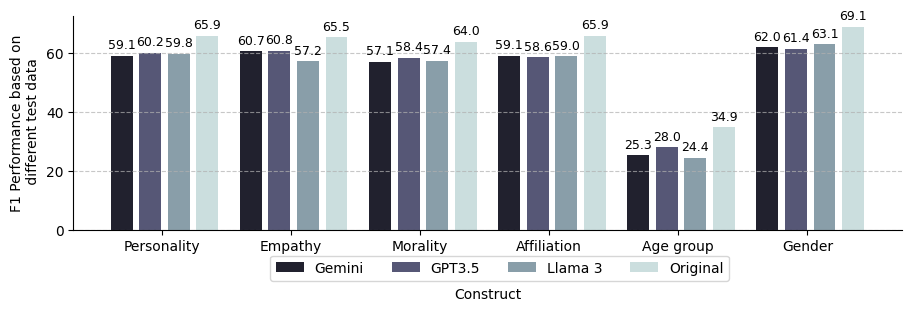

In [36]:
def show_the_comparison_between_values(summarized_results_values_df):

    df_to_work_on = summarized_results_values_df.copy()
    dataset_categories = ["essays", "wassa", "facebook", "party", "cohort", "gender"]

    results_per_model_dict = {
        "gemini": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gemini")
            ]["rewritten_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "gpt": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gpt")
            ]["rewritten_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "llama": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "llama")
            ]["rewritten_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "original": [
            df_to_work_on[df_to_work_on["dataset"] == dataset]["original_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
    }

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.17  # the width of the bars
    multiplier = 0
    multiplier_for_starts = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(9, 3))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 4))
    all_first_positions = []

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier_for_starts
        all_first_positions.append((x + offset).tolist())
        rects = ax.bar(
            x + offset,
            np.round(measurement, 2),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[int(multiplier)],
        )
        ax.bar_label(rects, padding=3, fmt="%.1f", fontsize=9)
        multiplier += 1
        multiplier_for_starts += 1 + 0.3

    # all_first_positions = list(zip(*all_first_positions))
    # print(ax.get_xlim())
    # print(ax.get_xticks())
    # for position, dataset in zip(all_first_positions, dataset_categories):
    #     print(position, dataset)
    #     # draw a baseline horizontal line
    #     print(min(position), max(position))
    #     ax.axhline(
    #         xmin=min(position) - 0.1,
    #         xmax=max(position) + 0.1,
    #         y=DATASET_TO_BASELINES[dataset] * 100,
    #         color="black",
    #         linestyle="--",
    #         alpha=0.7,
    #         linewidth=0.8,
    #     )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("F1 Performance based on\n different test data")
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width + 0.14,
        labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories],
    )
    ax.legend(loc="upper right", ncols=1)
    # ax.set_ylim(40, 70)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(loc="lower right", bbox_to_anchor=(0.8, -0.27), ncol=4)
    plt.xlabel("Construct", labelpad=24)

    plt.savefig(
        "figures/effect_of_llm_on_predictive_power_values.png",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()


show_the_comparison_between_values(summarized_results_values_df)

In [37]:
results_df.head(3)

,dataset,model,feature,LLM_model,label,rewritten_type,main_model_on_org,main_model_on_rewritten,p_value,main_model_on_rewritten_higher
0,essays,gradient_boosting,tfidf,gemini,CON,rephrase,0.661829,0.619467,0.238655,False
1,essays,gradient_boosting,openai,gemini,CON,rephrase,0.699093,0.618477,0.011868,False
2,essays,svm,tfidf,gemini,CON,rephrase,0.699330,0.645705,0.119877,False


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1390404429.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


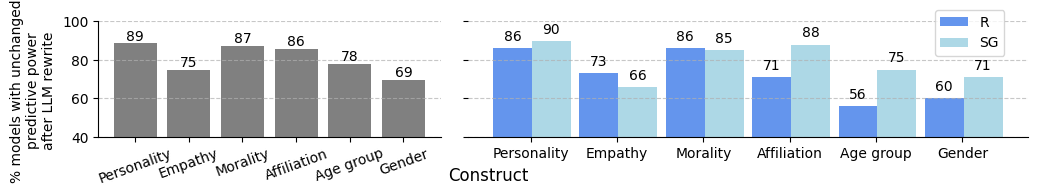

In [38]:
fig, axs = plt.subplots(
    1, 2, figsize=(12, 1.5), gridspec_kw={"width_ratios": [1.1, 1.8]}, sharey=True
)


def show_comparison_across_constructs(results_df, ax):
    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)
    significant_thresholds = dict(
        zip(
            df_to_work_on.groupby("dataset").size().index.tolist(),
            df_to_work_on.groupby("dataset").size().values.tolist(),
        )
    )

    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"] < 0.05 / significant_thresholds[row["dataset"]],
        axis=1,
    )
    # fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    color_pallette = "summer"
    colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 6))

    ratio_unchanged = (
        1
        - df_to_work_on.groupby(["dataset"])[
            "main_model_on_rewritten_significance"
        ].mean()
    ) * 100
    ratio_unchanged = ratio_unchanged.loc[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]

    ax.bar(ratio_unchanged.index, ratio_unchanged, color="grey", width=0.5)
    ax.bar_label(
        ax.bar(ratio_unchanged.index, ratio_unchanged, color="grey"), fmt="%.0f"
    )
    ax.set_xticklabels(
        [DATASET_TO_NAME[dataset] for dataset in ratio_unchanged.index], rotation=20
    )
    # ax.set_xlabel("Construct")
    ax.set_ylabel("% models with unchanged\npredictive power\nafter LLM rewrite", y=0.4)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.set_yticks([])
    ax.set_ylim(0, 100)

    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # plt.savefig("figures/significant_changes_overall.png", dpi=300, bbox_inches="tight")
    # plt.show()


show_comparison_across_constructs(results_df, ax=axs[0])


def show_comparison_across_constructs_and_prompts(results_df, ax):
    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    significant_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "rewritten_type"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "rewritten_type"]).size().values.tolist(),
        )
    )

    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significant_thresholds[(row["dataset"], row["rewritten_type"])],
        axis=1,
    )

    ratio_unchanged = (
        1
        - df_to_work_on.groupby(["dataset", "rewritten_type"])[
            "main_model_on_rewritten_significance"
        ].mean()
    )

    colors = ["cornflowerblue", "lightblue"]
    ratio_unchanged = ratio_unchanged.unstack()
    ratio_unchanged = ratio_unchanged.loc[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]
    categories = ratio_unchanged.index
    mean_values = {
        col: ratio_unchanged[col].values * 100 for col in ratio_unchanged.columns
    }

    x = np.arange(len(categories))  # the label locations
    width = 0.45  # the width of the bars
    multiplier = 0

    # fig, ax = plt.subplots(layout="constrained", figsize=(9, 2))

    for attribute, measurement in mean_values.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 0),
            width,
            label=REWRITTEN_TYPE_TO_SHORT[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(
        x + width - 0.24, [DATASET_TO_NAME[dataset] for dataset in categories]
    )
    ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(0.97, 1.16))
    # ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.95, -0.15))
    ax.set_ylim(40, 100)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # ax.set_yticks([])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    # ax.set_ylabel("% predictive powers\n unchanged after rewrite")
    # ax.set_xlabel("Construct")

    # plt.savefig(
    #     "figures/significant_changes_per_dataset_per_rewritten_type.png",
    #     dpi=300,
    #     bbox_inches="tight",
    # )
    # plt.show()


show_comparison_across_constructs_and_prompts(results_df, ax=axs[1])
fig.supxlabel("Construct", ha="center", va="center", fontsize=12, y=-0.15, x=0.45)
plt.subplots_adjust(wspace=0.06)
plt.savefig("figures/main_figure.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/1178218506.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


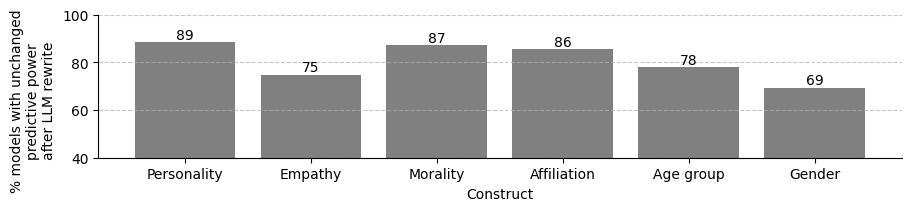

In [39]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(9, 2),
    layout="constrained",
)


def show_comparison_across_constructs(results_df, ax):
    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)
    significant_thresholds = dict(
        zip(
            df_to_work_on.groupby("dataset").size().index.tolist(),
            df_to_work_on.groupby("dataset").size().values.tolist(),
        )
    )

    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"] < 0.05 / significant_thresholds[row["dataset"]],
        axis=1,
    )
    # fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    color_pallette = "summer"
    colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 6))

    ratio_unchanged = (
        1
        - df_to_work_on.groupby(["dataset"])[
            "main_model_on_rewritten_significance"
        ].mean()
    ) * 100
    ratio_unchanged = ratio_unchanged.loc[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]

    ax.bar(ratio_unchanged.index, ratio_unchanged, color="grey", width=0.5)
    ax.bar_label(
        ax.bar(ratio_unchanged.index, ratio_unchanged, color="grey"), fmt="%.0f"
    )
    ax.set_xticklabels(
        [DATASET_TO_NAME[dataset] for dataset in ratio_unchanged.index], rotation=0
    )
    # ax.set_xlabel("Construct")
    ax.set_ylabel("% models with unchanged\npredictive power\nafter LLM rewrite", y=0.4)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.set_yticks([])
    ax.set_ylim(40, 100)

    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_xlabel("Construct")

    plt.savefig("figures/significant_changes_overall.png", dpi=300, bbox_inches="tight")
    plt.show()


show_comparison_across_constructs(results_df, ax=axs)

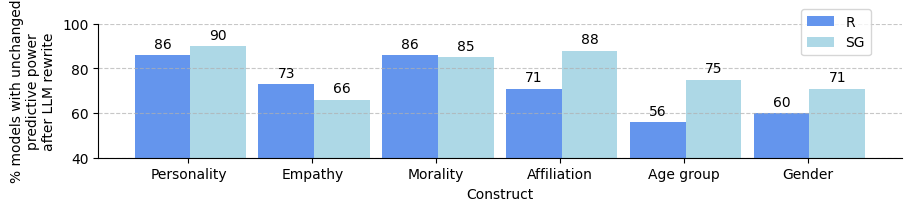

In [40]:
fig, axs = plt.subplots(
    1,
    1,
    figsize=(9, 2),
    layout="constrained",
)


def show_comparison_across_constructs_and_prompts(results_df, ax):
    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    significant_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "rewritten_type"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "rewritten_type"]).size().values.tolist(),
        )
    )

    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significant_thresholds[(row["dataset"], row["rewritten_type"])],
        axis=1,
    )

    ratio_unchanged = (
        1
        - df_to_work_on.groupby(["dataset", "rewritten_type"])[
            "main_model_on_rewritten_significance"
        ].mean()
    )

    colors = ["cornflowerblue", "lightblue"]
    ratio_unchanged = ratio_unchanged.unstack()
    ratio_unchanged = ratio_unchanged.loc[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]
    categories = ratio_unchanged.index
    mean_values = {
        col: ratio_unchanged[col].values * 100 for col in ratio_unchanged.columns
    }

    x = np.arange(len(categories))  # the label locations
    width = 0.45  # the width of the bars
    multiplier = 0

    # fig, ax = plt.subplots(layout="constrained", figsize=(9, 2))

    for attribute, measurement in mean_values.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 0),
            width,
            label=REWRITTEN_TYPE_TO_SHORT[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(
        x + width - 0.24, [DATASET_TO_NAME[dataset] for dataset in categories]
    )
    ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(0.97, 1.16))
    # ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.95, -0.15))
    ax.set_ylim(40, 100)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.set_yticks([])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_ylabel("% models with unchanged\npredictive power\nafter LLM rewrite")
    ax.set_xlabel("Construct")

    plt.savefig(
        "figures/significant_changes_per_dataset_per_rewritten_type.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


show_comparison_across_constructs_and_prompts(results_df, ax=axs)

In [41]:
results_df.to_csv("results_df.csv", index=False)

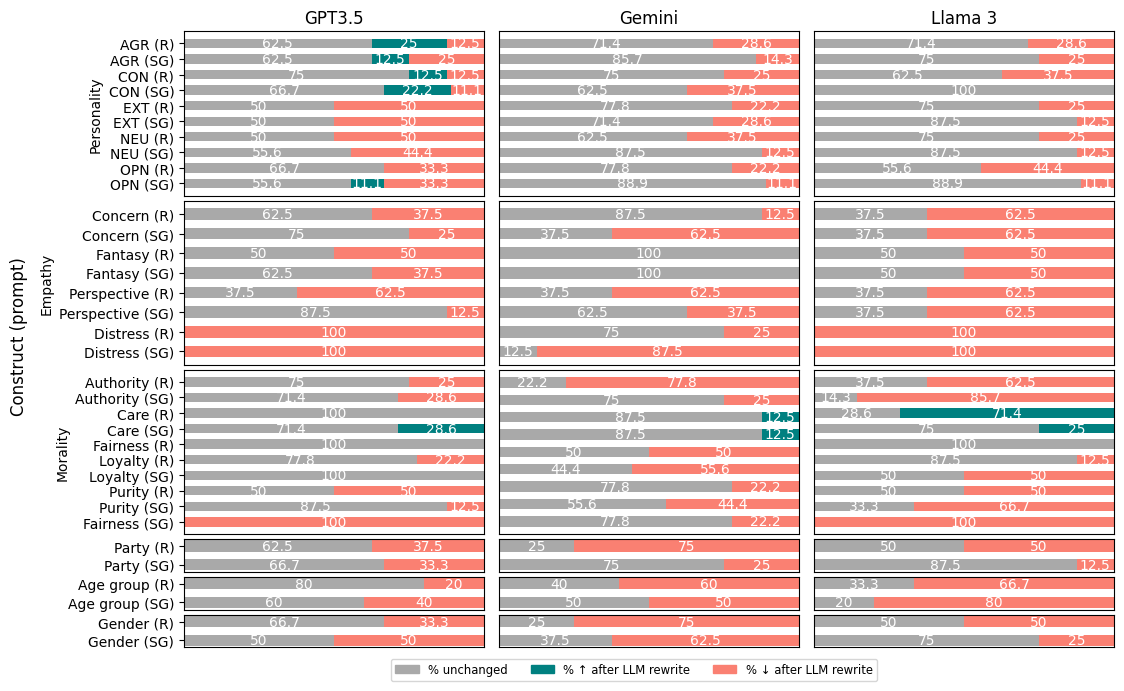

In [42]:
def show_differences_in_performance_across_all_dims(results_df):
    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    fig, axs = plt.subplots(
        nrows=6,
        ncols=3,
        figsize=(12, 8),
        gridspec_kw={"height_ratios": [5, 5, 5, 1, 1, 1]},
    )
    for dataset_index, dataset in enumerate(
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ):
        for llm_model_index, llm_model in enumerate(["gpt", "gemini", "llama"]):

            ax = axs[dataset_index, llm_model_index]

            all_values = {}
            for index, rewrite_type in enumerate(
                df_to_work_on["rewritten_type"].unique()
            ):
                x = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["LLM_model"] == llm_model)
                    & (df_to_work_on["rewritten_type"] == rewrite_type)
                ].copy()
                x = x.drop(columns=["dataset", "LLM_model", "rewritten_type"], axis=1)

                labels = []
                num_insignificant = []
                num_significant_main_model_on_rewritten_up = []
                num_significant_main_model_on_rewritten_down = []

                for label in x["label"].unique():
                    labels.append(label)
                    sub_df = x[x["label"] == label].copy()

                    sub_df["main_model_on_rewritten_significance"] = sub_df.apply(
                        lambda row: row["p_value"] < 0.05 / sub_df.shape[0], axis=1
                    )
                    num_insignificant.append(
                        (
                            sub_df[
                                sub_df["main_model_on_rewritten_significance"] == False
                            ].shape[0]
                        )
                        / sub_df.shape[0]
                        * 100
                    )
                    num_significant_main_model_on_rewritten_up.append(
                        sub_df[
                            (sub_df["main_model_on_rewritten_significance"] == True)
                            & (sub_df["main_model_on_rewritten_higher"] == True)
                        ].shape[0]
                        / sub_df.shape[0]
                        * 100
                    )
                    num_significant_main_model_on_rewritten_down.append(
                        sub_df[
                            (sub_df["main_model_on_rewritten_significance"] == True)
                            & (sub_df["main_model_on_rewritten_higher"] == False)
                        ].shape[0]
                        / sub_df.shape[0]
                        * 100
                    )

                df_to_visualize = pd.DataFrame(
                    {
                        "% unchanged": num_insignificant,
                        "% \u2191 after LLM rewrite": num_significant_main_model_on_rewritten_up,
                        "% \u2193 after LLM rewrite": num_significant_main_model_on_rewritten_down,
                    },
                    index=labels,
                )
                values = dict(
                    zip(df_to_visualize.index.tolist(), df_to_visualize.values.tolist())
                )
                values = {
                    f"{LABELS_TO_NAME[key]} ({REWRITTEN_TYPE_TO_SHORT[rewrite_type]})": value
                    for key, value in values.items()
                }
                all_values.update(values)

            columns = df_to_visualize.columns
            all_values = dict(sorted(all_values.items()))
            patches = survey(ax, all_values, columns, index)
            if llm_model_index != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
            if dataset_index == 0:
                ax.set_title(f"{LLM_TO_NAME[llm_model]}")
            if llm_model_index == 0:
                if dataset not in ["cohort", "gender", "party"]:
                    ax.set_ylabel(f"{DATASET_TO_NAME[dataset]}")

    # deduplicate the legend and remove the duplicates
    plt.legend(
        handles=patches,
        bbox_to_anchor=(-0.6, -1.2),
        loc="lower center",
        ncol=len(columns),
        fontsize="small",
    )
    # fig.suptitle(
    #     f"{DATASET_TO_NAME[dataset]} ({LLM_TO_NAME[llm_model]})", fontsize=16
    # )
    fig.supylabel("Construct (prompt)", x=-0.02)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.savefig(
        f"figures/differences_in_performance_across_all_dims.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_differences_in_performance_across_all_dims(results_df)

## Check the results comparing different prompts

In [43]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "rewritten_type"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "rewritten_type"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["rewritten_type"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

df_to_work_on_sg = (
    df_to_work_on[df_to_work_on["rewritten_type"] == "syntax_grammar"]
    .drop(
        columns=[
            "rewritten_type",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": "syntax_grammar"})
)
df_to_work_on_r = (
    df_to_work_on[df_to_work_on["rewritten_type"] == "rephrase"]
    .drop(
        columns=[
            "rewritten_type",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": "rephrase"})
)


merged_df = pd.merge(
    df_to_work_on_sg,
    df_to_work_on_r,
    on=["dataset", "LLM_model", "label", "model", "feature"],
    how="inner",
)

In [44]:
a_positive_positive = merged_df[
    (merged_df["syntax_grammar"] == 1) & (merged_df["rephrase"] == 1)
].shape[0]

b_positive_negative = merged_df[
    (merged_df["syntax_grammar"] == 1) & (merged_df["rephrase"] == 0)
].shape[0]

c_negative_positive = merged_df[
    (merged_df["syntax_grammar"] == 0) & (merged_df["rephrase"] == 1)
].shape[0]

d_negative_negative = merged_df[
    (merged_df["syntax_grammar"] == 0) & (merged_df["rephrase"] == 0)
].shape[0]

contingency_table = np.array(
    [
        [a_positive_positive, b_positive_negative],
        [c_negative_positive, d_negative_negative],
    ]
)

print(contingency_table)

from statsmodels.stats.contingency_tables import mcnemar


print(mcnemar(contingency_table, exact=False, correction=False))

[[ 34  31]
 [ 40 241]]
pvalue      0.285473830698583
statistic   1.1408450704225352


## Check the results comparing different classifiers

In [45]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)

# df_to_work_on = df_to_work_on[
#     df_to_work_on["dataset"].isin(["gender", "cohort", "party"])
# ]


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "model"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "model"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["model"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

df_to_work_on = df_to_work_on.drop(
    columns=[
        "p_value",
        "main_model_on_org",
        "main_model_on_rewritten",
        "main_model_on_rewritten_higher",
    ],
    axis=1,
)

In [46]:
df_to_work_on

,dataset,model,feature,LLM_model,label,rewritten_type,main_model_on_rewritten_significance
0,essays,gradient_boosting,tfidf,gemini,CON,rephrase,0
1,essays,gradient_boosting,openai,gemini,CON,rephrase,0
2,essays,svm,tfidf,gemini,CON,rephrase,0
3,essays,svm,openai,gemini,CON,rephrase,0
4,essays,random_forest,tfidf,gemini,CON,rephrase,1
...,...,...,...,...,...,...,...
913,party,random_forest,tfidf,gpt,party,syntax_grammar,1
914,party,random_forest,openai,gpt,party,syntax_grammar,0
915,party,regression,tfidf,gpt,party,syntax_grammar,1
916,party,regression,openai,gpt,party,syntax_grammar,0


In [47]:
import string

df_to_work_on["id"] = df_to_work_on.apply(
    lambda x: f"{x['dataset']}_{x['LLM_model']}_{x['feature']}_{x['label']}_{x['rewritten_type']}",
    axis=1,
)
df_to_work_on.drop(
    columns=["dataset", "LLM_model", "feature", "label", "rewritten_type"],
    axis=1,
    inplace=True,
)

df_to_work_on = df_to_work_on.dropna()

In [48]:
df_to_work_on_ids = df_to_work_on["id"].unique()
ids_to_simple_letters = dict(
    zip(df_to_work_on_ids, np.arange(len(df_to_work_on_ids)) + 1)
)

df_to_work_on["id"] = df_to_work_on["id"].map(ids_to_simple_letters)

In [49]:
df_to_work_on

,model,main_model_on_rewritten_significance,id
0,gradient_boosting,0,1
1,gradient_boosting,0,2
2,svm,0,1
3,svm,0,2
4,random_forest,1,1
...,...,...,...
913,random_forest,1,218
914,random_forest,0,219
915,regression,1,218
916,regression,0,219


In [50]:
indices_sizes = df_to_work_on.groupby("id").size()
indices_sizes.value_counts()

4    147
1     39
3     29
2      5
Name: count, dtype: int64

In [51]:
indices_unequal_three = indices_sizes[indices_sizes != 4].index.tolist()

df_to_work_on = df_to_work_on[~df_to_work_on["id"].isin(indices_unequal_three)]

In [52]:
df_to_work_on.to_csv("file_to_do_cochran_qtest.csv", index=False)

In [53]:
results_df["model"].unique()

array(['gradient_boosting', 'svm', 'random_forest', 'regression',
       'longformer'], dtype=object)

In [54]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "model"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "model"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["model"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

first_condition = "svm"
second_condition = "regression"

df_to_work_on_first = (
    df_to_work_on[df_to_work_on["model"] == first_condition]
    .drop(
        columns=[
            "model",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": first_condition})
)
df_to_work_on_second = (
    df_to_work_on[df_to_work_on["model"] == second_condition]
    .drop(
        columns=[
            "model",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": second_condition})
)


merged_df = pd.merge(
    df_to_work_on_first,
    df_to_work_on_second,
    on=["dataset", "LLM_model", "label", "rewritten_type", "feature"],
    how="inner",
)

In [55]:
a_positive_positive = merged_df[
    (merged_df[first_condition] == 1) & (merged_df[second_condition] == 1)
].shape[0]

b_positive_negative = merged_df[
    (merged_df[first_condition] == 1) & (merged_df[second_condition] == 0)
].shape[0]

c_negative_positive = merged_df[
    (merged_df[first_condition] == 0) & (merged_df[second_condition] == 1)
].shape[0]

d_negative_negative = merged_df[
    (merged_df[first_condition] == 0) & (merged_df[second_condition] == 0)
].shape[0]

contingency_table = np.array(
    [
        [a_positive_positive, b_positive_negative],
        [c_negative_positive, d_negative_negative],
    ]
)

print(contingency_table)

from statsmodels.stats.contingency_tables import mcnemar


print(mcnemar(contingency_table, exact=False, correction=False))

[[13 21]
 [46 93]]
pvalue      0.002256344240638694
statistic   9.328358208955224


## Check the results comparing different featurization techniques

In [56]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)

# df_to_work_on = df_to_work_on[
#     df_to_work_on["dataset"].isin(["gender", "cohort", "party"])
# ]


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "feature"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "feature"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["feature"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

df_to_work_on = df_to_work_on.drop(
    columns=[
        "p_value",
        "main_model_on_org",
        "main_model_on_rewritten",
        "main_model_on_rewritten_higher",
    ],
    axis=1,
)

In [57]:
import string

df_to_work_on["id"] = df_to_work_on.apply(
    lambda x: f"{x['dataset']}_{x['LLM_model']}_{x['model']}_{x['label']}_{x['rewritten_type']}",
    axis=1,
)
df_to_work_on.drop(
    columns=["dataset", "LLM_model", "model", "label", "rewritten_type"],
    axis=1,
    inplace=True,
)

df_to_work_on = df_to_work_on.dropna()

In [58]:
results_df["model"].unique()

array(['gradient_boosting', 'svm', 'random_forest', 'regression',
       'longformer'], dtype=object)

In [59]:
df_to_work_on_ids = df_to_work_on["id"].unique()
ids_to_simple_letters = dict(
    zip(df_to_work_on_ids, np.arange(len(df_to_work_on_ids)) + 1)
)

df_to_work_on["id"] = df_to_work_on["id"].map(ids_to_simple_letters)

In [60]:
df_to_work_on

,feature,main_model_on_rewritten_significance,id
0,tfidf,0,1
1,openai,0,1
2,tfidf,0,2
3,openai,0,2
4,tfidf,1,3
...,...,...,...
913,tfidf,1,391
914,openai,0,391
915,tfidf,0,392
916,openai,0,392


In [61]:
indices_sizes = df_to_work_on.groupby("id").size()
indices_sizes.value_counts()

2    331
1     62
Name: count, dtype: int64

In [62]:
indices_unequal_three = indices_sizes[indices_sizes != 2].index.tolist()

df_to_work_on = df_to_work_on[~df_to_work_on["id"].isin(indices_unequal_three)]

In [63]:
df_to_work_on.to_csv("file_to_do_cochran_qtest.csv", index=False)

In [64]:
results_df["feature"].unique()

array(['tfidf', 'openai', 'longformer'], dtype=object)

In [65]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "feature"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "feature"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["feature"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

first_condition = "tfidf"
second_condition = "openai"

df_to_work_on_first = (
    df_to_work_on[df_to_work_on["feature"] == first_condition]
    .drop(
        columns=[
            "feature",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": first_condition})
)
df_to_work_on_second = (
    df_to_work_on[df_to_work_on["feature"] == second_condition]
    .drop(
        columns=[
            "feature",
            "main_model_on_org",
            "main_model_on_rewritten",
            "p_value",
            "main_model_on_rewritten_higher",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": second_condition})
)


merged_df = pd.merge(
    df_to_work_on_first,
    df_to_work_on_second,
    on=["dataset", "LLM_model", "label", "rewritten_type", "model"],
    how="inner",
)

In [66]:
a_positive_positive = merged_df[
    (merged_df[first_condition] == 1) & (merged_df[second_condition] == 1)
].shape[0]

b_positive_negative = merged_df[
    (merged_df[first_condition] == 1) & (merged_df[second_condition] == 0)
].shape[0]

c_negative_positive = merged_df[
    (merged_df[first_condition] == 0) & (merged_df[second_condition] == 1)
].shape[0]

d_negative_negative = merged_df[
    (merged_df[first_condition] == 0) & (merged_df[second_condition] == 0)
].shape[0]

contingency_table = np.array(
    [
        [a_positive_positive, b_positive_negative],
        [c_negative_positive, d_negative_negative],
    ]
)

print(contingency_table)

from statsmodels.stats.contingency_tables import mcnemar


print(mcnemar(contingency_table, exact=False, correction=False))

[[ 26  49]
 [ 38 218]]
pvalue      0.23826926934637124
statistic   1.3908045977011494


## Check the results comparing different LLMs

In [67]:
df_to_work_on = results_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)

df_to_work_on = df_to_work_on[
    df_to_work_on["dataset"].isin(["gender", "cohort", "party"])
]


significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "LLM_model"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "LLM_model"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["LLM_model"])],
    axis=1,
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype("int")

df_to_work_on = df_to_work_on.drop(
    columns=[
        "p_value",
        "main_model_on_org",
        "main_model_on_rewritten",
        "main_model_on_rewritten_higher",
    ],
    axis=1,
)

In [68]:
import string

df_to_work_on["id"] = df_to_work_on.apply(
    lambda x: f"{x['dataset']}_{x['model']}_{x['feature']}_{x['label']}_{x['rewritten_type']}",
    axis=1,
)
df_to_work_on.drop(
    columns=["dataset", "model", "feature", "label", "rewritten_type"],
    axis=1,
    inplace=True,
)

df_to_work_on = df_to_work_on.dropna()

In [69]:
df_to_work_on_ids = df_to_work_on["id"].unique()
ids_to_simple_letters = dict(
    zip(df_to_work_on_ids, np.arange(len(df_to_work_on_ids)) + 1)
)

df_to_work_on["id"] = df_to_work_on["id"].map(ids_to_simple_letters)

In [70]:
indices_sizes = df_to_work_on.groupby("id").size()
indices_unequal_three = indices_sizes[indices_sizes != 3].index.tolist()

df_to_work_on = df_to_work_on[~df_to_work_on["id"].isin(indices_unequal_three)]

In [71]:
df_to_work_on.to_csv("file_to_do_cochran_qtest.csv", index=False)

dataset       cohort     essays   facebook     gender      party      wassa
LLM_model                                                                  
gemini     45.454545  95.000000  85.915493  37.500000  62.500000  68.000000
gpt        80.000000  69.047619  92.307692  70.588235  82.352941  70.000000
llama      54.545455  95.061728  70.967742  81.250000  87.500000  54.901961


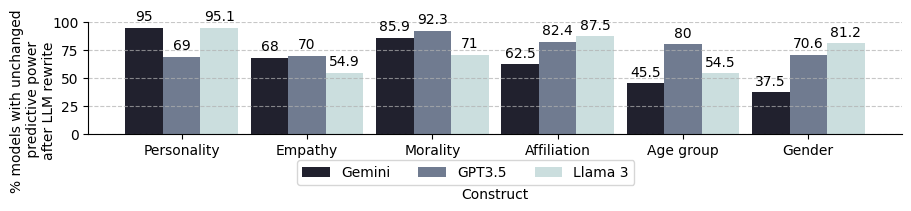

In [72]:
def show_the_comparison_between_llms(results_df):

    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    significance_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().values.tolist(),
        )
    )
    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significance_thresholds[(row["dataset"], row["LLM_model"])],
        axis=1,
    )

    results_per_model = (
        df_to_work_on.groupby(["dataset", "LLM_model"])[
            "main_model_on_rewritten_significance"
        ].value_counts(normalize=True)
        * 100
    )

    results_per_model = results_per_model[:, :, False].unstack(level=0)
    print(results_per_model)
    results_per_model = results_per_model[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]
    dataset_categories = results_per_model.columns

    results_per_model_dict = dict(
        zip(results_per_model.index, results_per_model.values.tolist())
    )

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(9, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 3))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 1),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(
        "% models with unchanged\n predictive power\nafter LLM rewrite",
        labelpad=-3,
        y=0.3,
    )
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width, labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories]
    )
    ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.68, -0.17))
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel("Construct", labelpad=21)

    plt.savefig("figures/rewritten_by_llm_per_model.png", bbox_inches="tight", dpi=300)

    plt.show()


show_the_comparison_between_llms(results_df)

dataset                essays      wassa   facebook      party     cohort  \
model                                                                       
gradient_boosting  100.000000  67.441860  71.428571  83.333333  62.500000   
longformer          91.666667        NaN  92.857143        NaN        NaN   
random_forest       68.333333  77.777778  66.666667  50.000000        NaN   
regression          73.584906  25.000000  95.833333  66.666667  58.333333   
svm                 93.333333  77.777778  81.132075  75.000000  58.333333   

dataset               gender  
model                         
gradient_boosting  50.000000  
longformer               NaN  
random_forest      75.000000  
regression         41.666667  
svm                58.333333  


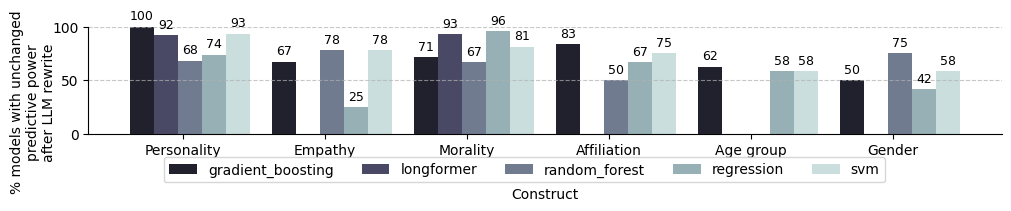

In [73]:
def show_the_comparison_between_classifiers(results_df):

    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)
    num_models = df_to_work_on["model"].nunique()

    significance_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "model"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "model"]).size().values.tolist(),
        )
    )
    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significance_thresholds[(row["dataset"], row["model"])],
        axis=1,
    )

    results_per_model = (
        df_to_work_on.groupby(["dataset", "model"])[
            "main_model_on_rewritten_significance"
        ].value_counts(normalize=True)
        * 100
    )

    results_per_model = results_per_model[:, :, False].unstack(level=0)
    results_per_model = results_per_model[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]

    print(results_per_model)
    dataset_categories = results_per_model.columns

    results_per_model_dict = dict(
        zip(results_per_model.index, results_per_model.values.tolist())
    )

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.17  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(10, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, num_models))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 1),
            width,
            label=attribute,
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3, fontsize=9, fmt="%.0f")
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(
        "% models with unchanged\npredictive power\nafter LLM rewrite",
        labelpad=-3,
        y=0.3,
    )
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width + 0.12,
        labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories],
    )
    ax.legend(loc="upper right", ncols=5, bbox_to_anchor=(0.88, -0.15))
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel("Construct", labelpad=21)

    plt.savefig(
        "figures/rewritten_by_llm_per_classifier.png", bbox_inches="tight", dpi=300
    )

    plt.show()


show_the_comparison_between_classifiers(results_df)

dataset        essays      wassa   facebook      party     cohort     gender
feature                                                                     
longformer  91.666667        NaN  92.857143        NaN        NaN        NaN
openai      89.915966  65.384615  85.714286  95.833333  64.285714  75.000000
tfidf       85.087719  73.972603  82.558140  62.500000  66.666667  54.166667
92.85714285714286
95.83333333333334
85.08771929824562


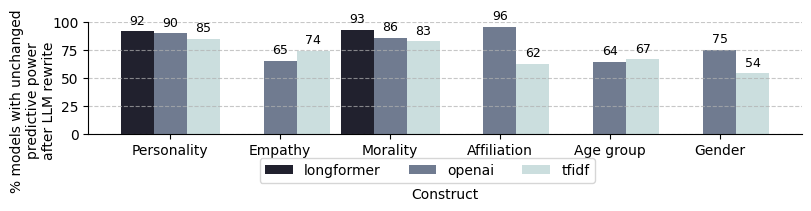

In [74]:
def show_the_comparison_between_featurizations(results_df):

    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)
    num_features = df_to_work_on["feature"].nunique()

    significance_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "feature"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "feature"]).size().values.tolist(),
        )
    )
    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significance_thresholds[(row["dataset"], row["feature"])],
        axis=1,
    )

    results_per_model = (
        df_to_work_on.groupby(["dataset", "feature"])[
            "main_model_on_rewritten_significance"
        ].value_counts(normalize=True)
        * 100
    )

    results_per_model = results_per_model[:, :, False].unstack(level=0)
    results_per_model = results_per_model[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]

    print(results_per_model)

    dataset_categories = results_per_model.columns

    results_per_model_dict = dict(
        zip(results_per_model.index, results_per_model.values.tolist())
    )

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(8, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, num_features))

    for attribute, measurement in results_per_model_dict.items():
        max_measurement = max(measurement)
        print(max_measurement)
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 1),
            width,
            label=attribute,
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3, fontsize=9, fmt="%.0f")
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(
        "% models with unchanged\npredictive power\nafter LLM rewrite",
        labelpad=-3,
        y=0.3,
    )
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width, labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories]
    )
    ax.legend(loc="upper right", ncols=5, bbox_to_anchor=(0.72, -0.15))
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel("Construct", labelpad=21)

    plt.savefig(
        "figures/rewritten_by_llm_per_feature.png", bbox_inches="tight", dpi=300
    )

    plt.show()


show_the_comparison_between_featurizations(results_df)

## Checking whether the LLMs can augment the data

In [75]:
def get_diff_from_aug_results(df):

    df_to_work_on = df.copy()

    all_datasets = []
    all_labels = []
    all_llm_models = []
    all_model_types = []
    all_features = []
    all_rewritten_types = []
    model_original_performance = []
    model_augmented_performance = []
    p_values = []

    for dataset in df_to_work_on["dataset"].unique():
        for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
            "label"
        ].unique():
            for llm_model in df_to_work_on["LLM_model"].unique():
                for model_type in df_to_work_on["model_type"].unique():
                    for feature in df_to_work_on["feature"].unique():
                        for rewritten_type in df_to_work_on["rewritten_type"].unique():
                            if (
                                feature == "longformer" and model_type != "longformer"
                            ) or (
                                model_type == "longformer" and feature != "longformer"
                            ):
                                continue
                            sub_df = df_to_work_on[
                                (df_to_work_on["dataset"] == dataset)
                                & (df_to_work_on["label"] == label)
                                & (df_to_work_on["LLM_model"] == llm_model)
                                & (df_to_work_on["model_type"] == model_type)
                                & (df_to_work_on["feature"] == feature)
                                & (df_to_work_on["rewritten_type"] == rewritten_type)
                            ].copy()

                            all_datasets.append(dataset)
                            all_labels.append(label)
                            all_llm_models.append(llm_model)
                            all_model_types.append(model_type)
                            all_features.append(feature)
                            all_rewritten_types.append(rewritten_type)
                            model_original_performance.append(
                                sub_df[sub_df["reverse"] == 0][
                                    "best_results_on_test"
                                ].mean()
                            )
                            model_augmented_performance.append(
                                sub_df[sub_df["reverse"] == 2][
                                    "best_results_on_test"
                                ].mean()
                            )

                            _, p_value = stats.ttest_ind(
                                sub_df[sub_df["reverse"] == 0]["best_results_on_test"],
                                sub_df[sub_df["reverse"] == 2]["best_results_on_test"],
                            )
                            p_values.append(p_value)

    diff_results_df = pd.DataFrame(
        {
            "dataset": all_datasets,
            "label": all_labels,
            "LLM_model": all_llm_models,
            "model_type": all_model_types,
            "feature": all_features,
            "rewritten_type": all_rewritten_types,
            "model_original_performance": model_original_performance,
            "model_augmented_performance": model_augmented_performance,
            "p_value": p_values,
        }
    )
    diff_results_df["is_augmented_higher"] = (
        diff_results_df["model_augmented_performance"]
        > diff_results_df["model_original_performance"]
    )
    return diff_results_df

In [76]:
diff_results_df = get_diff_from_aug_results(df)
diff_results_df.head(3)

,dataset,label,LLM_model,model_type,feature,rewritten_type,model_original_performance,model_augmented_performance,p_value,is_augmented_higher
0,essays,CON,gemini,gradient_boosting,tfidf,rephrase,0.661829,0.649804,0.755360,False
1,essays,CON,gemini,gradient_boosting,tfidf,syntax_grammar,0.683495,0.557877,0.005132,False
2,essays,CON,gemini,gradient_boosting,openai,rephrase,0.699093,0.651920,0.449907,False


In [77]:
def get_reversed_summarized_df_for_augmentation(diff_results_df):

    df_to_work_on = diff_results_df.copy()

    all_datasets = []
    all_llm_models = []
    all_original_test_values = []
    all_aug_test_values = []

    for dataset in ["essays", "wassa", "facebook", "gender", "cohort", "party"]:
        for llm_model in ["gpt", "llama", "gemini"]:
            sub_df = df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == llm_model)
            ].copy()

            all_datasets.append(dataset)
            all_llm_models.append(llm_model)

            all_original_test_values.append(sub_df["model_original_performance"].mean())
            all_aug_test_values.append(sub_df["model_augmented_performance"].mean())

    summarized_results_values_df = pd.DataFrame(
        {
            "dataset": all_datasets,
            "LLM_model": all_llm_models,
            "original_values": all_original_test_values,
            "aug_values": all_aug_test_values,
        }
    )
    return summarized_results_values_df

In [78]:
df[((df["dataset"] == "gender") & (df["reverse"] == 2) & (df["LLM_model"] == "gpt"))]

,file_name,dataset,LLM_model,label,model_type,feature,reverse,rewritten_type,random_seed,best_results,best_results_on_test,best_results_on_rewritten,rewritten_type_str,baseline,good_row
78769,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,regression,openai,2,rephrase,1709750694,0.866216,0.626391,0.594037,rephrase_gpt,0.5,True
78772,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,random_forest,openai,2,rephrase,1709748958,0.781338,0.589080,0.563748,rephrase_gpt,0.5,True
78808,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,random_forest,tfidf,2,syntax_grammar,1709700079,0.745597,0.696581,0.620093,syntax_grammar_gpt,0.5,True
78834,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,random_forest,tfidf,2,syntax_grammar,1709698988,0.763524,0.729524,0.713627,syntax_grammar_gpt,0.5,True
78856,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,regression,openai,2,rephrase,1709750119,0.859403,0.588611,0.609402,rephrase_gpt,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91324,LLM_model=gpt_label_column=gender_model_type=g...,gender,gpt,gender,gradient_boosting,tfidf,2,syntax_grammar,1709684341,0.748622,0.612760,0.649912,syntax_grammar_gpt,0.5,True
91328,LLM_model=gpt_label_column=gender_model_type=g...,gender,gpt,gender,gradient_boosting,tfidf,2,syntax_grammar,1709682730,0.761852,0.610366,0.608536,syntax_grammar_gpt,0.5,True
91332,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,random_forest,tfidf,2,syntax_grammar,1709699443,0.733871,0.654277,0.666239,syntax_grammar_gpt,0.5,True
91334,LLM_model=gpt_label_column=gender_model_type=r...,gender,gpt,gender,regression,tfidf,2,rephrase,1709735737,0.789861,0.731061,0.720345,rephrase_gpt,0.5,True


In [79]:
diff_results_with_aug_summarized = get_reversed_summarized_df_for_augmentation(
    diff_results_df
)
diff_results_with_aug_summarized

,dataset,LLM_model,original_values,aug_values
0,essays,gpt,0.631435,0.586850
1,essays,llama,0.667085,0.599679
2,essays,gemini,0.677334,0.601542
3,wassa,gpt,0.653714,0.649829
4,wassa,llama,0.655645,0.654486
5,wassa,gemini,0.654811,0.647810
6,facebook,gpt,0.643300,0.581486
7,facebook,llama,0.643488,0.579071
8,facebook,gemini,0.631996,0.579466
9,gender,gpt,0.703145,0.663350


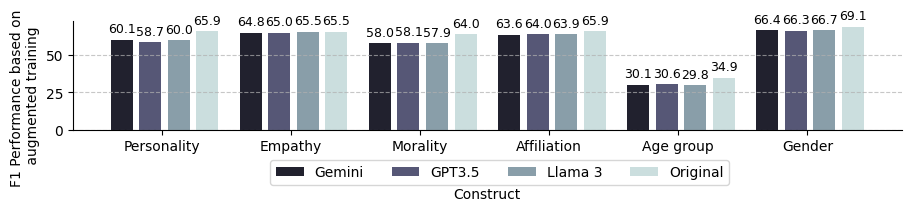

In [80]:
def show_the_comparison_between_values_aug(diff_results_with_aug_summarized):

    df_to_work_on = diff_results_with_aug_summarized.copy()
    dataset_categories = ["essays", "wassa", "facebook", "party", "cohort", "gender"]

    results_per_model_dict = {
        "gemini": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gemini")
            ]["aug_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "gpt": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gpt")
            ]["aug_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "llama": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "llama")
            ]["aug_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "original": [
            df_to_work_on[df_to_work_on["dataset"] == dataset]["original_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
    }

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.17  # the width of the bars
    multiplier = 0
    multiplier_for_starts = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(9, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 4))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier_for_starts
        rects = ax.bar(
            x + offset,
            np.round(measurement, 2),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[int(multiplier)],
        )
        ax.bar_label(rects, padding=3, fmt="%.1f", fontsize=9)
        multiplier += 1
        multiplier_for_starts += 1 + 0.3

    # for index, dataset in enumerate(dataset_categories):
    #     # draw a baseline horizontal line
    #     ax.axhline(
    #         xmin=0.35 * index,
    #         xmax=0.35 * (index + 1) - 0.03,
    #         y=DATASET_TO_BASELINES[dataset] * 100,
    #         color="black",
    #         linestyle="--",
    #         alpha=0.7,
    #         linewidth=0.8,
    #     )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("F1 Performance based on\n augmented training", y=0.3)
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width + 0.14,
        labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories],
    )
    ax.legend(loc="upper right", ncols=1)
    # ax.set_ylim(45, 70)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(loc="lower right", bbox_to_anchor=(0.8, -0.57), ncol=4)
    plt.xlabel("Construct", labelpad=24)

    plt.savefig(
        "figures/effect_of_llm_on_augmentation_values.png",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()


show_the_comparison_between_values_aug(diff_results_with_aug_summarized)

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3771740640.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


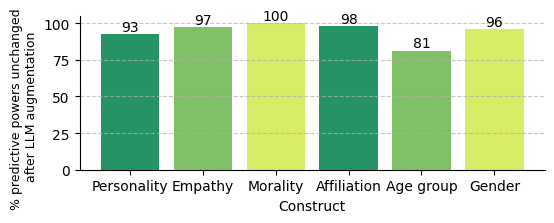

In [81]:
def show_the_effect_of_LLM_augmentation(diff_results_df):
    df_to_work_on = diff_results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)
    significant_thresholds = dict(
        zip(
            df_to_work_on.groupby("dataset").size().index.tolist(),
            df_to_work_on.groupby("dataset").size().values.tolist(),
        )
    )

    df_to_work_on["is_difference_significant"] = df_to_work_on.apply(
        lambda row: row["p_value"] < 0.05 / significant_thresholds[row["dataset"]],
        axis=1,
    )
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    color_pallette = "summer"
    colors = plt.get_cmap(color_pallette)(np.linspace(0.15, 0.85, 3))

    ratio_unchanged = (
        1 - df_to_work_on.groupby(["dataset"])["is_difference_significant"].mean()
    ) * 100
    ratio_unchanged = ratio_unchanged.loc[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]

    plt.bar(ratio_unchanged.index, ratio_unchanged, color=colors)
    plt.bar_label(
        plt.bar(ratio_unchanged.index, ratio_unchanged, color=colors), fmt="%.0f"
    )
    plt.gca().set_xticklabels(
        [DATASET_TO_NAME[dataset] for dataset in ratio_unchanged.index]
    )
    plt.xlabel("Construct")
    plt.ylabel(
        "% predictive powers unchanged\n after LLM augmentation", y=0.4, fontsize=9
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.savefig("figures/effect_of_llm_augmentation.png", dpi=300, bbox_inches="tight")
    plt.show()


show_the_effect_of_LLM_augmentation(diff_results_df)

In [82]:
diff_results_df.head(3)

,dataset,label,LLM_model,model_type,feature,rewritten_type,model_original_performance,model_augmented_performance,p_value,is_augmented_higher
0,essays,CON,gemini,gradient_boosting,tfidf,rephrase,0.661829,0.649804,0.755360,False
1,essays,CON,gemini,gradient_boosting,tfidf,syntax_grammar,0.683495,0.557877,0.005132,False
2,essays,CON,gemini,gradient_boosting,openai,rephrase,0.699093,0.651920,0.449907,False


dataset        essays  wassa  facebook  party     cohort  gender
LLM_model                                                       
gemini     100.000000   98.0     100.0  100.0  72.727273  100.00
gpt         78.750000   94.0     100.0   87.5  70.000000   81.25
llama       96.153846  100.0     100.0  100.0  45.454545   87.50


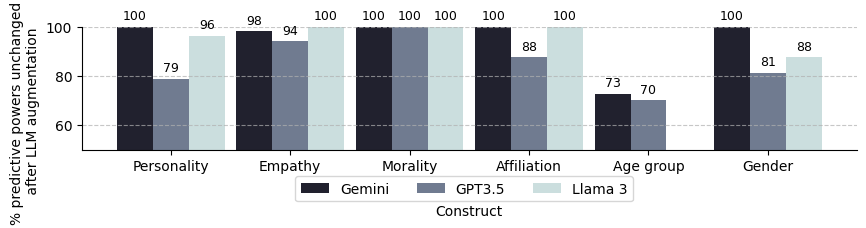

In [83]:
def show_the_effect_of_LLM_augmentation_per_LLM(diff_results_df):
    df_to_work_on = diff_results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    significance_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().values.tolist(),
        )
    )
    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significance_thresholds[(row["dataset"], row["LLM_model"])],
        axis=1,
    )

    results_per_model = (
        df_to_work_on.groupby(["dataset", "LLM_model"])[
            "main_model_on_rewritten_significance"
        ].value_counts(normalize=True)
        * 100
    )

    results_per_model = results_per_model[:, :, False].unstack(level=0)
    results_per_model = results_per_model[
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ]
    print(results_per_model)
    dataset_categories = results_per_model.columns

    results_per_model_dict = dict(
        zip(results_per_model.index, results_per_model.values.tolist())
    )

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10, 1.6))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 3))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 1),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3, fontsize=9, fmt="%.0f")
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("% predictive powers unchanged\n after LLM augmentation", y=0.30)
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width, labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories]
    )
    ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.72, -0.16))
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_ylim(50, 100)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel("Construct", labelpad=22)

    # plt.subplots_adjust(bottom=0.2, top=1.4)
    plt.savefig(
        "figures/effect_of_llm_augmentation_per_llm.png", dpi=300, bbox_inches="tight"
    )
    plt.show()


show_the_effect_of_LLM_augmentation_per_LLM(diff_results_df)

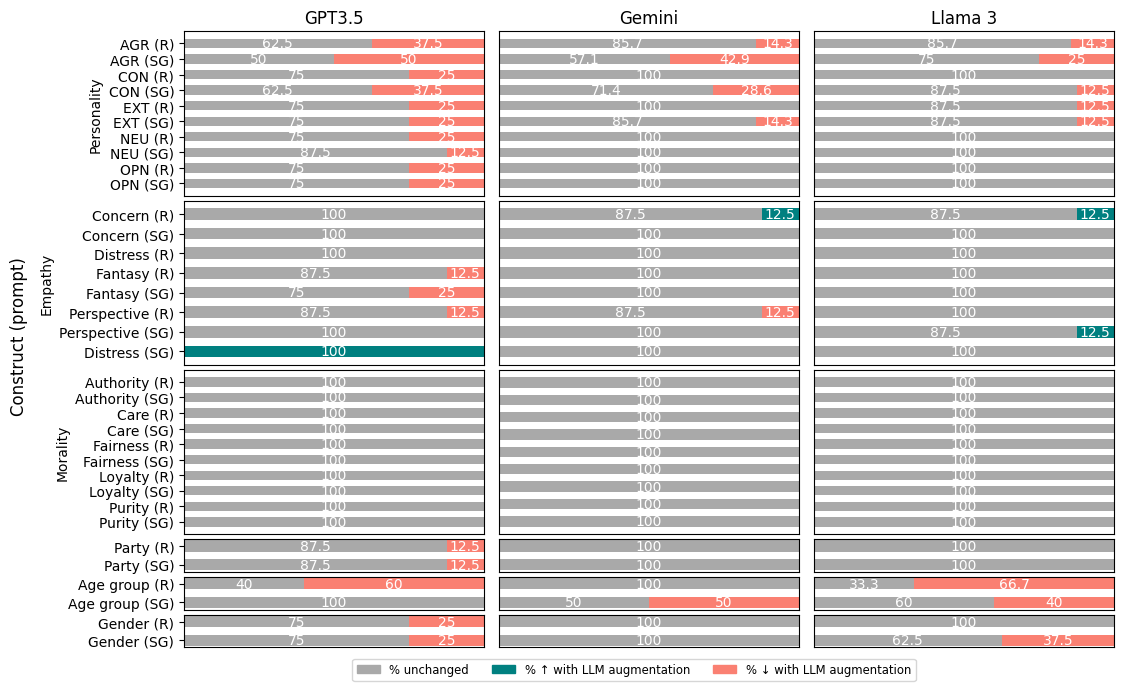

In [84]:
def show_the_augmentation_effect_per_dataset_and_dim(diff_results_df):

    df_to_work_on = diff_results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    fig, axs = plt.subplots(
        nrows=6,
        ncols=3,
        figsize=(12, 8),
        gridspec_kw={"height_ratios": [5, 5, 5, 1, 1, 1]},
    )
    for dataset_index, dataset in enumerate(
        ["essays", "wassa", "facebook", "party", "cohort", "gender"]
    ):
        for llm_model_index, llm_model in enumerate(["gpt", "gemini", "llama"]):

            ax = axs[dataset_index, llm_model_index]
            all_values = {}
            for index, rewrite_type in enumerate(
                df_to_work_on["rewritten_type"].unique()
            ):
                x = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["LLM_model"] == llm_model)
                    & (df_to_work_on["rewritten_type"] == rewrite_type)
                ].copy()
                x = x.drop(columns=["dataset", "LLM_model", "rewritten_type"], axis=1)

                labels = []
                num_insignificant = []
                num_significant_aug_up = []
                num_significant_aug_down = []

                for label in x["label"].unique():
                    labels.append(label)
                    sub_df = x[x["label"] == label].copy()

                    sub_df["is_difference_significant"] = sub_df.apply(
                        lambda row: row["p_value"] < 0.05 / sub_df.shape[0], axis=1
                    )

                    num_insignificant.append(
                        (sub_df[sub_df["is_difference_significant"] == False].shape[0])
                        / sub_df.shape[0]
                        * 100
                    )
                    num_significant_aug_up.append(
                        sub_df[
                            (sub_df["is_difference_significant"] == True)
                            & (sub_df["is_augmented_higher"] == True)
                        ].shape[0]
                        / sub_df.shape[0]
                        * 100
                    )
                    num_significant_aug_down.append(
                        sub_df[
                            (sub_df["is_difference_significant"] == True)
                            & (sub_df["is_augmented_higher"] == False)
                        ].shape[0]
                        / sub_df.shape[0]
                        * 100
                    )

                df_to_visualize = pd.DataFrame(
                    {
                        "% unchanged": num_insignificant,
                        "% \u2191 with LLM augmentation": num_significant_aug_up,
                        "% \u2193 with LLM augmentation": num_significant_aug_down,
                    },
                    index=labels,
                )

                values = dict(
                    zip(df_to_visualize.index.tolist(), df_to_visualize.values.tolist())
                )
                values = {
                    f"{LABELS_TO_NAME[key]} ({REWRITTEN_TYPE_TO_SHORT[rewrite_type]})": val
                    for key, val in values.items()
                }
                all_values.update(values)

            all_values = dict(sorted(all_values.items()))
            columns = df_to_visualize.columns
            patches = survey(ax, all_values, columns, index)
            if llm_model_index != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
            if dataset_index == 0:
                ax.set_title(f"{LLM_TO_NAME[llm_model]}")
            if llm_model_index == 0:
                if dataset not in ["cohort", "party", "gender"]:
                    ax.set_ylabel(f"{DATASET_TO_NAME[dataset]}")

    # deduplicate the legend and remove the duplicates
    plt.legend(
        handles=patches,
        bbox_to_anchor=(-0.6, -1.2),
        loc="lower center",
        ncol=len(columns),
        fontsize="small",
    )

    # fig.suptitle(f"{DATASET_TO_NAME[dataset]} ({LLM_TO_NAME[llm_model]})", fontsize=16)
    # plt.savefig(
    #     f"figures/effect_of_augmentation_{llm_model}_{dataset}.png",
    #     bbox_inches="tight",
    #     dpi=300,
    # )
    fig.supylabel("Construct (prompt)", x=-0.02)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.savefig(
        f"figures/effect_of_augmentation.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_the_augmentation_effect_per_dataset_and_dim(diff_results_df)

## Check if the level of constructs goes higher or lower

In [85]:
def get_changes_in_predictions(json_data, target_label):
    count_unchanged = 0
    count_higher = 0
    count_lower = 0
    all_ids = json_data["test"]["ids"]
    id_to_label = dict(zip(all_ids, json_data["test"]["labels"]))
    id_to_predicted_label = dict(zip(all_ids, json_data["test"]["predicted_labels"]))
    if target_label == "cohort":
        id_to_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_label.items()
        }
        id_to_predicted_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_predicted_label.items()
        }

    all_ids_rewritten = json_data["rewritten"]["ids"]
    id_to_rewritten_predicted_label = dict(
        zip(all_ids_rewritten, json_data["rewritten"]["predicted_labels"])
    )
    if target_label == "cohort":
        id_to_rewritten_predicted_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_rewritten_predicted_label.items()
        }

    selected_ids = [
        id_ for id_, label in id_to_label.items() if label == id_to_predicted_label[id_]
    ]

    selected_ids = [id_ for id_ in selected_ids if id_ in all_ids_rewritten]

    for id_ in selected_ids:
        predicted_label = id_to_predicted_label[id_]
        rewritten_predicted_label = id_to_rewritten_predicted_label[id_]
        if predicted_label == rewritten_predicted_label:
            count_unchanged += 1
        elif predicted_label > rewritten_predicted_label:
            count_lower += 1
        else:
            count_higher += 1
    return (
        count_unchanged / len(selected_ids),
        count_higher / len(selected_ids),
        count_lower / len(selected_ids),
    )

In [86]:
def get_ids_that_have_changed(json_data, target_label):
    unchanged = []
    changed = []
    all_ids = json_data["test"]["ids"]
    id_to_label = dict(zip(all_ids, json_data["test"]["labels"]))
    id_to_predicted_label = dict(zip(all_ids, json_data["test"]["predicted_labels"]))
    if target_label == "cohort":
        id_to_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_label.items()
        }
        id_to_predicted_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_predicted_label.items()
        }

    all_ids_rewritten = json_data["rewritten"]["ids"]
    id_to_rewritten_predicted_label = dict(
        zip(all_ids_rewritten, json_data["rewritten"]["predicted_labels"])
    )
    if target_label == "cohort":
        id_to_rewritten_predicted_label = {
            key: FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES[val]
            for key, val in id_to_rewritten_predicted_label.items()
        }

    selected_ids = [
        id_ for id_, label in id_to_label.items() if label == id_to_predicted_label[id_]
    ]

    selected_ids = [id_ for id_ in selected_ids if id_ in all_ids_rewritten]

    for id_ in selected_ids:
        predicted_label = id_to_predicted_label[id_]
        rewritten_predicted_label = id_to_rewritten_predicted_label[id_]
        if predicted_label == rewritten_predicted_label:
            unchanged.append(id_)
        else:
            changed.append(id_)
    return (
        unchanged,
        changed,
    )

In [87]:
def get_changes_in_predictions_all(json_data):
    all_ids = []
    all_changes = []

    all_ids = json_data["test"]["ids"]
    id_to_label = dict(zip(all_ids, json_data["test"]["labels"]))
    id_to_predicted_label = dict(zip(all_ids, json_data["test"]["predicted_labels"]))

    all_ids_rewritten = json_data["rewritten"]["ids"]
    id_to_rewritten_predicted_label = dict(
        zip(all_ids_rewritten, json_data["rewritten"]["predicted_labels"])
    )

    selected_ids = [
        id_ for id_, label in id_to_label.items() if label == id_to_predicted_label[id_]
    ]

    selected_ids = [id_ for id_ in selected_ids if id_ in all_ids_rewritten]

    for id_ in selected_ids:
        all_ids.append(id_)
        predicted_label = id_to_predicted_label[id_]
        rewritten_predicted_label = id_to_rewritten_predicted_label[id_]
        if predicted_label == rewritten_predicted_label:
            all_changes.append("unchanged")
        elif predicted_label > rewritten_predicted_label:
            all_changes.append("lower")
        else:
            all_changes.append("higher")
    return (
        all_ids,
        all_changes,
    )

In [88]:
predictions_file_path = "LLM_model={}_label_column={}_model_type={}_features={}_output_type=classification_reverse=0_rewritten_type={}_random_seed={}.json"

In [89]:
def get_the_ids_that_have_changed(df):

    df_to_work_on = df.copy()

    all_llm_models = []
    all_datasets = []
    all_rewritten_types = []
    all_unchanged = []
    all_changed = []

    for llm_model in ["gpt", "gemini", "llama"]:
        for dataset in ["essays", "wassa", "facebook", "cohort", "party", "gender"]:
            for rewritten_type in ["syntax_grammar", "rephrase"]:

                sub_df = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["rewritten_type"] == rewritten_type)
                    & (df_to_work_on["LLM_model"] == llm_model)
                    & (df_to_work_on["reverse"] == 0)
                ].copy()

                agg_unchanged = []
                agg_changed = []

                for _, row in sub_df.iterrows():
                    try:
                        file_path = predictions_file_path.format(
                            row["LLM_model"],
                            row["label"],
                            row["model_type"],
                            row["feature"],
                            row["rewritten_type_str"],
                            row["random_seed"],
                        )
                        complete_file_path = os.path.join(
                            (
                                f"{dataset}_logs"
                                if dataset not in ["cohort", "gender", "party"]
                                else "political_logs"
                            ),
                            file_path,
                        )
                        if not os.path.exists(complete_file_path):
                            continue
                        with open(
                            complete_file_path,
                            "r",
                        ) as f:
                            json_data = json.load(f)
                    except Exception as e:
                        continue
                    try:
                        unchanged_ids, changed_ids = get_ids_that_have_changed(
                            json_data, row["label"]
                        )
                    except Exception as e:
                        print(e)
                        print(complete_file_path)
                        continue
                    agg_unchanged.extend(unchanged_ids)
                    agg_changed.extend(changed_ids)

                all_llm_models.append(llm_model)
                all_rewritten_types.append(rewritten_type)
                all_datasets.append(dataset)
                all_unchanged.append(agg_unchanged)
                all_changed.append(agg_changed)

    return pd.DataFrame(
        {
            "LLM_model": all_llm_models,
            "dataset": all_datasets,
            "rewritten_type": all_rewritten_types,
            "unchanged": all_unchanged,
            "changed": all_changed,
        }
    )


change_and_unchanged_per_id = get_the_ids_that_have_changed(df)

In [90]:
import pickle

with open("../datasets/similarities_dict_with_keys.pkl", "rb") as f:
    similarities_dict = pickle.load(f)

In [91]:
rewritten_type_to_short = {
    "syntax_grammar": "SG",
    "rephrase": "R",
}
dataset_to_dataset_name = {
    "essays": "essays",
    "wassa": "wassa",
    "facebook": "facebook",
    "cohort": "political",
    "party": "political",
    "gender": "political",
}
list(similarities_dict["gpt"][("essays", "SG")].items())[:5]

[('1999_554750', 0.9847888756577724),
 ('1998_659638', 0.9868499631717939),
 ('1997_790797', 0.9783150730387948),
 ('2000_962395', 0.9946231699279621),
 ('1998_961471', 0.9817651731569513)]

In [92]:
change_and_unchanged_per_id["unchanged_similarities"] = (
    change_and_unchanged_per_id.apply(
        lambda x: [
            similarities_dict[x["LLM_model"]][
                (
                    dataset_to_dataset_name[x["dataset"]],
                    rewritten_type_to_short[x["rewritten_type"]],
                )
            ][id_]
            for id_ in x["unchanged"]
            if id_
            in similarities_dict[x["LLM_model"]][
                (
                    dataset_to_dataset_name[x["dataset"]],
                    rewritten_type_to_short[x["rewritten_type"]],
                )
            ]
        ],
        axis=1,
    )
)

In [93]:
change_and_unchanged_per_id["changed_similarities"] = change_and_unchanged_per_id.apply(
    lambda x: [
        similarities_dict[x["LLM_model"]][
            (
                dataset_to_dataset_name[x["dataset"]],
                rewritten_type_to_short[x["rewritten_type"]],
            )
        ][id_]
        for id_ in x["changed"]
        if id_
        in similarities_dict[x["LLM_model"]][
            (
                dataset_to_dataset_name[x["dataset"]],
                rewritten_type_to_short[x["rewritten_type"]],
            )
        ]
    ],
    axis=1,
)

In [94]:
import numpy as np


def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [95]:
change_and_unchanged_per_id.head(3)

,LLM_model,dataset,rewritten_type,unchanged,changed,unchanged_similarities,changed_similarities
0,gpt,essays,syntax_grammar,"[1999_756180, 2002_167717, 1997_747589, 2000_7...","[1999_676943, 1997_430172, 2004_497, 2004_203,...","[0.9869212300327497, 0.980893555844454, 0.9853...","[0.9747560835329537, 0.9641717679515295, 0.978..."
1,gpt,essays,rephrase,"[2000_715921, 2003_34, 1997_654932, 1998_16020...","[1998_845446, 1997_318159, 1998_874263, 1999_6...","[0.9711956177995261, 0.9656429643259585, 0.977...","[0.9781640835335144, 0.7524151682545229, 0.974..."
2,gpt,wassa,syntax_grammar,"[16, 51, 17, 14, 29, 2, 53, 50, 2, 27, 45, 9, ...","[21, 48, 15, 57, 46, 43, 40, 10, 46, 40, 37, 4...","[0.9635813423106625, 0.9658265946542632, 0.972...","[0.9677329581844943, 0.9645788601035453, 0.980..."


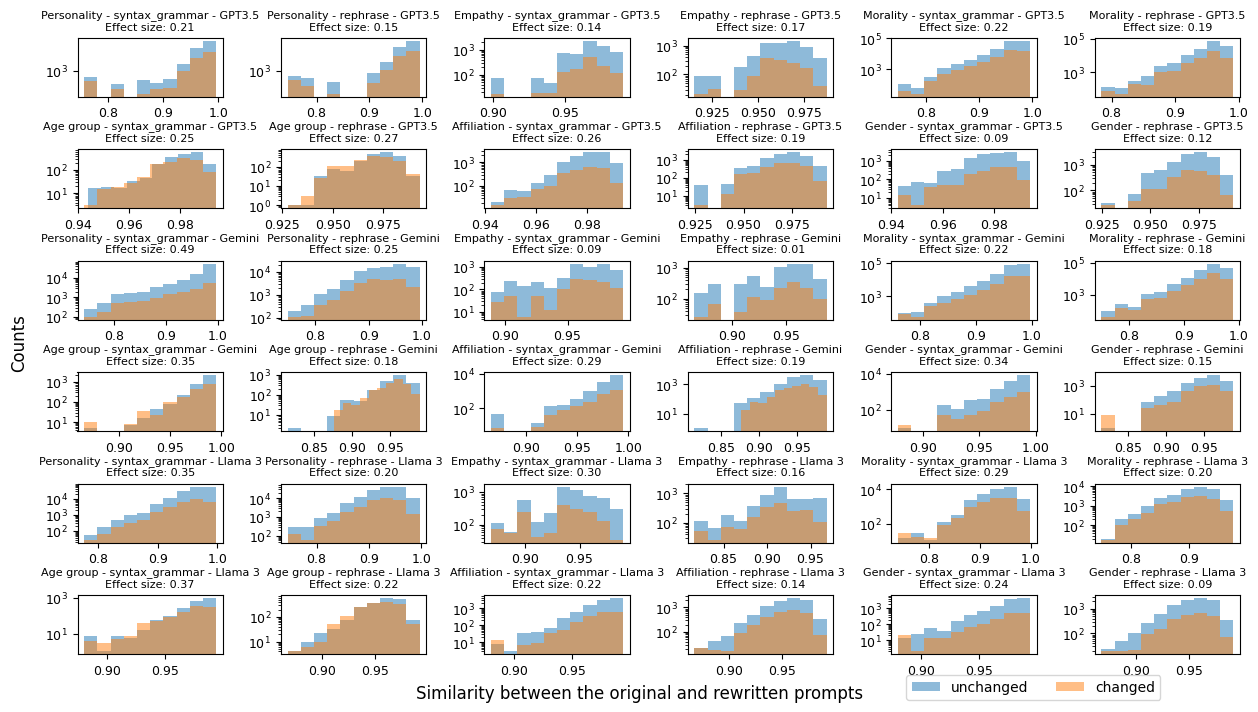

In [96]:
fig, axs = plt.subplots(6, 6, figsize=(15, 8))
for ax, (index, row) in zip(axs.flatten(), change_and_unchanged_per_id.iterrows()):
    ax.hist(row["unchanged_similarities"], bins=10, alpha=0.5, label="unchanged")
    ax.hist(row["changed_similarities"], bins=10, alpha=0.5, label="changed")
    ax.set(
        yscale="log",
    )
    _, p_value = stats.ttest_ind(
        row["unchanged_similarities"], row["changed_similarities"]
    )
    effect_size = cohend(row["unchanged_similarities"], row["changed_similarities"])
    ax.set_title(
        f"{DATASET_TO_NAME[row['dataset']]} - {row['rewritten_type']} - {LLM_TO_NAME[row['LLM_model']]}\nEffect size: {effect_size:.2f}",
        fontsize=8,
    )
    # change the font of the xticklabels
    for label in ax.get_xticklabels():
        label.set_fontsize(9)
    for label in ax.get_yticklabels():
        label.set_fontsize(9)
plt.legend(bbox_to_anchor=(0.5, -0.9), loc="lower right", ncols=2)
fig.subplots_adjust(hspace=0.9, wspace=0.40)
fig.supxlabel("Similarity between the original and rewritten prompts", y=0.05)
fig.supylabel("Counts", x=0.08)
plt.show()

In [97]:
from collections import defaultdict, Counter

In [98]:
def get_all_the_predictions(df):

    df_to_work_on = df.copy()

    all_llm_models = []
    all_datasets = []
    all_labels = []
    all_original_predictions = []
    all_rewritten_predictions = []

    for llm_model in ["gpt", "gemini", "llama"]:
        for dataset in ["essays", "wassa", "facebook", "cohort", "party", "gender"]:
            for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
                "label"
            ].unique():

                sub_df = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["label"] == label)
                    & (df_to_work_on["LLM_model"] == llm_model)
                    & (df_to_work_on["reverse"] == 0)
                ].copy()

                num_values_original = defaultdict(list)
                num_values_rewritten = defaultdict(list)

                for _, row in sub_df.iterrows():
                    try:
                        file_path = predictions_file_path.format(
                            row["LLM_model"],
                            row["label"],
                            row["model_type"],
                            row["feature"],
                            row["rewritten_type_str"],
                            row["random_seed"],
                        )
                        complete_file_path = os.path.join(
                            (
                                f"{dataset}_logs"
                                if dataset not in ["cohort", "gender", "party"]
                                else "political_logs"
                            ),
                            file_path,
                        )
                        if not os.path.exists(complete_file_path):
                            continue
                        with open(
                            complete_file_path,
                            "r",
                        ) as f:
                            json_data = json.load(f)
                            run_test_predicted_labels = dict(
                                Counter(json_data["test"]["predicted_labels"])
                            )
                            run_rewritten_predicted_labels = dict(
                                Counter(json_data["rewritten"]["predicted_labels"])
                            )
                            for key in np.unique(json_data["test"]["labels"]).tolist():
                                num_values_original[key].append(
                                    run_test_predicted_labels.get(key, 0)
                                )
                            for key in np.unique(json_data["test"]["labels"]).tolist():
                                num_values_rewritten[key].append(
                                    run_rewritten_predicted_labels.get(key, 0)
                                )

                    except Exception as e:
                        print(e)
                        continue

                all_llm_models.append(llm_model)
                all_labels.append(label)
                all_datasets.append(dataset)
                all_original_predictions.append(num_values_original)
                all_rewritten_predictions.append(num_values_rewritten)

    return pd.DataFrame(
        {
            "LLM_model": all_llm_models,
            "dataset": all_datasets,
            "label": all_labels,
            "original": all_original_predictions,
            "rewritten": all_rewritten_predictions,
        }
    )


all_predicted_labels_df = get_all_the_predictions(df)

In [99]:
def get_differences_distributions(
    all_predicted_labels_df, index_in_df=0, show_plot=False, is_cohort=False
):
    if is_cohort:
        differences_original = []
        for i in range(len(all_predicted_labels_df["original"][index_in_df][0])):
            all_values = [
                all_predicted_labels_df["original"][index_in_df][j][i]
                for j in [0, 1, 2, 3]
            ]
            max_value = max(all_values)
            min_value = min(all_values)
            differences_original.append((max_value - min_value) / sum(all_values))

        differences_rewritten = []
        for i in range(len(all_predicted_labels_df["rewritten"][index_in_df][0])):
            all_values = [
                all_predicted_labels_df["rewritten"][index_in_df][j][i]
                for j in [0, 1, 2, 3]
            ]
            max_value = max(all_values)
            min_value = min(all_values)
            differences_rewritten.append((max_value - min_value) / sum(all_values))
    else:
        differences_original = [
            np.abs(
                all_predicted_labels_df["original"][index_in_df][0][i]
                - all_predicted_labels_df["original"][index_in_df][1][i]
            )
            / (
                all_predicted_labels_df["original"][index_in_df][0][i]
                + all_predicted_labels_df["original"][index_in_df][1][i]
            )
            for i in range(len(all_predicted_labels_df["original"][index_in_df][0]))
        ]

        differences_rewritten = [
            np.abs(
                all_predicted_labels_df["rewritten"][index_in_df][0][i]
                - all_predicted_labels_df["rewritten"][index_in_df][1][i]
            )
            / (
                all_predicted_labels_df["rewritten"][index_in_df][0][i]
                + all_predicted_labels_df["rewritten"][index_in_df][1][i]
            )
            for i in range(len(all_predicted_labels_df["rewritten"][index_in_df][0]))
        ]

    # do a non-parametric test to see if the pairs are different
    from scipy.stats import wilcoxon

    stat, p = wilcoxon(
        differences_rewritten, differences_original, alternative="greater"
    )
    # print("Statistics=%.3f, p=%.3f" % (stat, p))
    if not show_plot:
        return stat, p, differences_original, differences_rewritten

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    ax.hist(
        differences_original,
        bins=10,
        alpha=0.5,
        label="original",
        density=True,
        color="skyblue",
    )
    ax.hist(
        differences_rewritten,
        bins=10,
        alpha=0.5,
        label="rewritten",
        density=True,
        color="salmon",
    )

    # show the means for each group
    ax.axvline(
        np.mean(differences_original), color="skyblue", linestyle="--", linewidth=1
    )
    ax.axvline(
        np.mean(differences_rewritten), color="salmon", linestyle="--", linewidth=1
    )

    # ax.set_title(
    #     f"Original vs Rewritten\nWilcoxon test p-value: {p:.3f}",
    #     fontsize=10,
    # )
    plt.legend()
    plt.show()
    return stat, p, differences_original, differences_rewritten

In [100]:
all_stats = []
all_p_values = []
all_differences_original = []
all_differences_rewritten = []
for index in range(all_predicted_labels_df.shape[0]):
    stat, p, differences_original, differences_rewritten = (
        get_differences_distributions(
            all_predicted_labels_df,
            index_in_df=index,
            is_cohort=all_predicted_labels_df.loc[index, "dataset"] == "cohort",
        )
    )
    all_stats.append(stat)
    all_p_values.append(p)
    all_differences_original.append(differences_original)
    all_differences_rewritten.append(differences_rewritten)

all_predicted_labels_df["stat"] = all_stats
all_predicted_labels_df["p_value"] = all_p_values
all_predicted_labels_df["differences_original"] = all_differences_original
all_predicted_labels_df["differences_rewritten"] = all_differences_rewritten
all_predicted_labels_df["significance"] = all_predicted_labels_df["p_value"] < 0.05

In [101]:
import seaborn as sns

In [102]:
def create_df_for_diff_distributions_sns_plot(df):
    all_labels = []
    all_modes = []
    all_values = []
    all_significance = []
    all_stats = []

    for index, row in df.iterrows():
        all_labels.extend([row["label"]] * len(row["differences_original"]))
        all_modes.extend(["original"] * len(row["differences_original"]))
        all_significance.extend([row["p_value"]] * len(row["differences_original"]))
        all_stats.extend([row["stat"]] * len(row["differences_original"]))
        all_values.extend(row["differences_original"])

        all_labels.extend([row["label"]] * len(row["differences_rewritten"]))
        all_modes.extend(["rewritten"] * len(row["differences_rewritten"]))
        all_significance.extend([row["p_value"]] * len(row["differences_rewritten"]))
        all_stats.extend([row["stat"]] * len(row["differences_rewritten"]))
        all_values.extend(row["differences_rewritten"])

    return pd.DataFrame(
        {
            "label": all_labels,
            "mode": all_modes,
            "value": all_values,
            "significance": all_significance,
            "stat": all_stats,
        }
    )

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([LABELS_TO_NAME[label]], rotation=45)
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

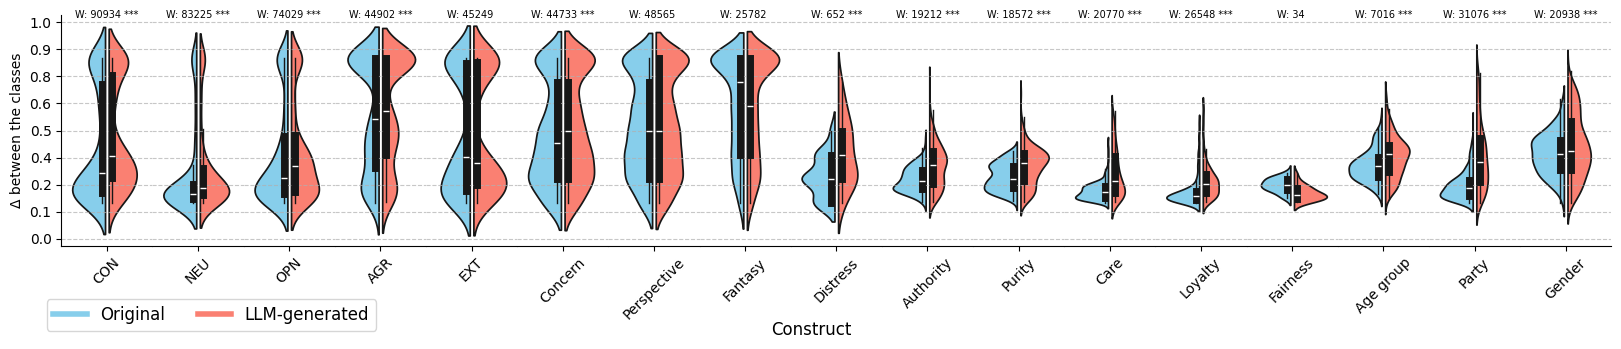

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([LABELS_TO_NAME[label]], rotation=45)
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

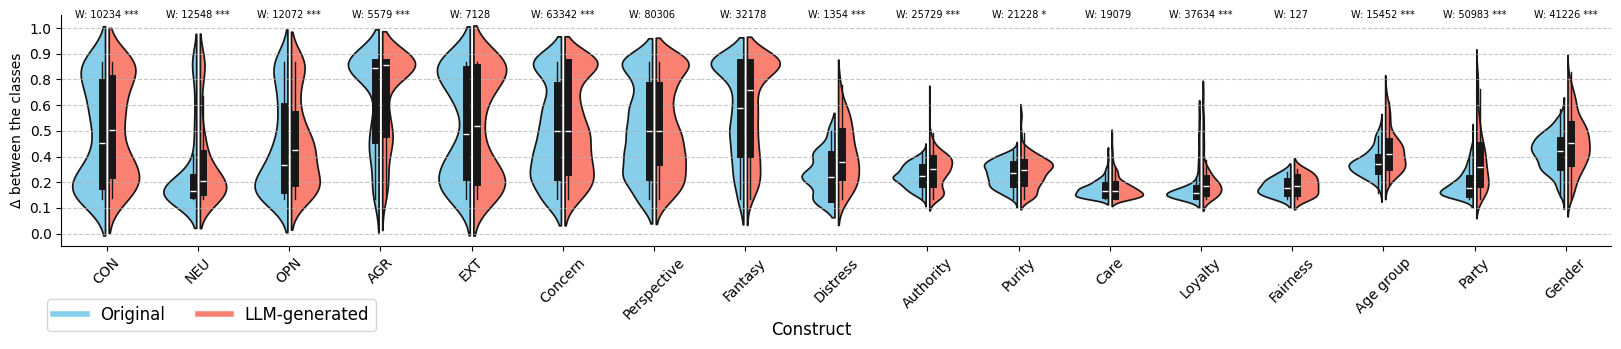

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([LABELS_TO_NAME[label]], rotation=45)
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.violinplot(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_18566/3290272547.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

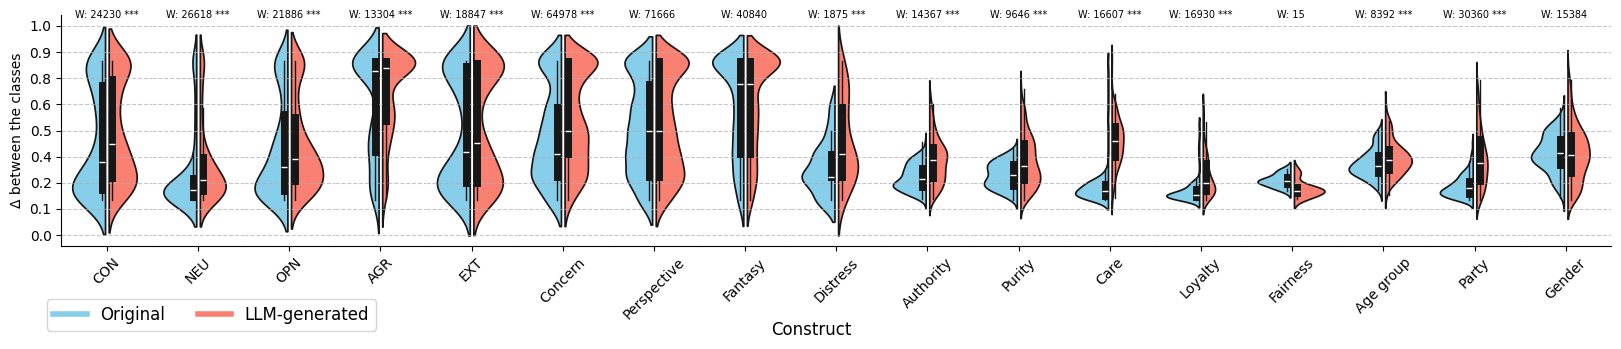

In [103]:
for llm_model in ["gpt", "gemini", "llama"]:
    df_for_diff_distributions_sns_plot = create_df_for_diff_distributions_sns_plot(
        all_predicted_labels_df[all_predicted_labels_df["LLM_model"] == llm_model]
    )

    fig, axs = plt.subplots(1, 17, figsize=(20, 3), sharey=True)
    for ax, label in zip(axs, df_for_diff_distributions_sns_plot["label"].unique()):
        sns.violinplot(
            data=df_for_diff_distributions_sns_plot[
                df_for_diff_distributions_sns_plot["label"] == label
            ],
            x="label",
            y="value",
            hue="mode",
            split=True,
            inner="box",
            gap=0.1,
            common_norm=True,
            ax=ax,
            inner_kws=dict(
                box_width=5,
                whis_width=1,
            ),
            color="skyblue",
            # palette=[".4", ".7"],
        )
        colors = ["skyblue", "salmon"]
        from matplotlib.collections import PolyCollection
        from matplotlib.colors import to_rgb

        for ind, violin in enumerate(ax.findobj(PolyCollection)):
            if ind % 2 != 0:
                rgb = to_rgb(colors[1])
            else:
                rgb = to_rgb(colors[0])
            violin.set_facecolor(rgb)
        # remove x axis label
        ax.set_xlabel("")
        ax.set_xticklabels([LABELS_TO_NAME[label]], rotation=45)
        # remove ticks too
        # ax.set_xticks([])
        ax.grid(visible=True, axis="y", linestyle="--", alpha=0.7)

        # for each violin plot, if the significance is True, then we want to show a star on top of the axis
        p_value = df_for_diff_distributions_sns_plot[
            df_for_diff_distributions_sns_plot["label"] == label
        ]["significance"].unique()[0]
        stat = df_for_diff_distributions_sns_plot[
            df_for_diff_distributions_sns_plot["label"] == label
        ]["stat"].unique()[0]

        # if p_value < 0.05:
        ax.text(
            0.5,
            1.0,
            f"W: {stat:.0f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}",
            fontsize=7,
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
        # elif p_value < 0.01:
        #     ax.text(
        #         0.5,
        #         1.0,
        #         "**",
        #         fontsize=20,
        #         ha="center",
        #         va="center",
        #         transform=ax.transAxes,
        #     )
        # elif p_value < 0.05:
        #     ax.text(
        #         0.5,
        #         1.0,
        #         "*",
        #         fontsize=20,
        #         ha="center",
        #         va="center",
        #         transform=ax.transAxes,
        #     )

        # else:
        #     ax.text(
        #         0.5,
        #         1.0,
        #         "",
        #         fontsize=20,
        #         ha="center",
        #         va="center",
        #         transform=ax.transAxes,
        #     )

        # if the significance is True, then we want to show a star

        # ax.set_title(label)

    # deduplicate the legend and remove the duplicates
    handles, labels = ax.get_legend_handles_labels()
    # handles are salmon and skyblue
    handles = [
        plt.Line2D([0], [0], color=colors[0], lw=4),
        plt.Line2D([0], [0], color=colors[1], lw=4),
    ]
    fig.legend(
        handles,
        ["Original", "LLM-generated"],
        bbox_to_anchor=(0.2, -0.20),
        loc="lower center",
        ncol=2,
        fontsize="large",
    )

    axs[0].set_yticks(np.linspace(-0.25, 1.25, len(axs[0].get_yticks())))
    axs[0].set_yticklabels(
        [np.round(x, 1) for x in np.linspace(0, 1, len(axs[0].get_yticks()))]
    )
    axs[0].set_ylabel("Δ between the classes", fontsize=10)

    # for y_value in [0]:
    #     fig.add_subplot(111, frame_on=False).axhline(y=y_value, color='gray', linestyle='--', linewidth=1, zorder=-1)

    # remove all other legends
    for ax in axs:
        ax.get_legend().remove()
        # remove the top and right spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    for ax in axs[1:]:
        ax.set_ylabel("")
        # ax.set_yticks([])
        # ax.set_yticklabels([])
        # remove the
        ax.yaxis.set_ticks_position("none")
        ax.spines["left"].set_visible(False)

    fig.subplots_adjust(hspace=0.1, wspace=0.00)
    fig.supxlabel("Construct", y=-0.2)

    plt.savefig(
        f"figures/homogeneity_of_predictions_{llm_model}.png",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()

In [104]:
def get_the_changes_in_predictions(df):

    df_to_work_on = df.copy()

    all_llm_models = []
    all_datasets = []
    all_labels = []
    all_unchanged = []
    all_higher = []
    all_lower = []

    for llm_model in ["gpt", "gemini", "llama"]:
        for dataset in ["essays", "wassa", "facebook", "cohort", "party", "gender"]:
            for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
                "label"
            ].unique():

                sub_df = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["label"] == label)
                    & (df_to_work_on["LLM_model"] == llm_model)
                    & (df_to_work_on["reverse"] == 0)
                ].copy()

                agg_unchanged = []
                agg_higher = []
                agg_lower = []

                for _, row in sub_df.iterrows():
                    try:
                        file_path = predictions_file_path.format(
                            row["LLM_model"],
                            row["label"],
                            row["model_type"],
                            row["feature"],
                            row["rewritten_type_str"],
                            row["random_seed"],
                        )
                        complete_file_path = os.path.join(
                            (
                                f"{dataset}_logs"
                                if dataset not in ["cohort", "gender", "party"]
                                else "political_logs"
                            ),
                            file_path,
                        )
                        if not os.path.exists(complete_file_path):
                            continue
                        with open(
                            complete_file_path,
                            "r",
                        ) as f:
                            json_data = json.load(f)
                    except Exception as e:
                        continue
                    try:
                        perc_unchanged, perc_higher, perc_lower = (
                            get_changes_in_predictions(json_data, row["label"])
                        )
                    except Exception as e:
                        print(e)
                        print(complete_file_path)
                        continue
                    agg_unchanged.append(perc_unchanged)
                    agg_higher.append(perc_higher)
                    agg_lower.append(perc_lower)

                all_llm_models.append(llm_model)
                all_labels.append(label)
                all_datasets.append(dataset)
                all_unchanged.append(agg_unchanged)
                all_higher.append(agg_higher)
                all_lower.append(agg_lower)

    return pd.DataFrame(
        {
            "LLM_model": all_llm_models,
            "dataset": all_datasets,
            "label": all_labels,
            "unchanged": all_unchanged,
            "higher": all_higher,
            "lower": all_lower,
        }
    )


diff_in_predicted_labels_df = get_the_changes_in_predictions(df)

In [105]:
def get_the_changes_in_predictions_with_prompts(df):

    df_to_work_on = df.copy()

    all_prompts = []
    all_datasets = []
    all_labels = []
    all_unchanged = []
    all_higher = []
    all_lower = []

    for prompt in ["syntax_grammar", "rephrase"]:
        for dataset in ["essays", "wassa", "facebook", "cohort", "party", "gender"]:
            for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
                "label"
            ].unique():

                sub_df = df_to_work_on[
                    (df_to_work_on["dataset"] == dataset)
                    & (df_to_work_on["label"] == label)
                    & (df_to_work_on["rewritten_type"] == prompt)
                    & (df_to_work_on["reverse"] == 0)
                ].copy()

                agg_unchanged = []
                agg_higher = []
                agg_lower = []

                for _, row in sub_df.iterrows():
                    try:
                        file_path = predictions_file_path.format(
                            row["LLM_model"],
                            row["label"],
                            row["model_type"],
                            row["feature"],
                            row["rewritten_type_str"],
                            row["random_seed"],
                        )
                        complete_file_path = os.path.join(
                            (
                                f"{dataset}_logs"
                                if dataset not in ["cohort", "gender", "party"]
                                else "political_logs"
                            ),
                            file_path,
                        )
                        if not os.path.exists(complete_file_path):
                            continue
                        with open(
                            complete_file_path,
                            "r",
                        ) as f:
                            json_data = json.load(f)
                    except Exception as e:
                        continue
                    try:
                        perc_unchanged, perc_higher, perc_lower = (
                            get_changes_in_predictions(json_data, row["label"])
                        )
                    except Exception as e:
                        print(e)
                        print(complete_file_path)
                        continue
                    agg_unchanged.append(perc_unchanged)
                    agg_higher.append(perc_higher)
                    agg_lower.append(perc_lower)

                all_prompts.append(prompt)
                all_labels.append(label)
                all_datasets.append(dataset)
                all_unchanged.append(agg_unchanged)
                all_higher.append(agg_higher)
                all_lower.append(agg_lower)

    return pd.DataFrame(
        {
            "prompt": all_prompts,
            "dataset": all_datasets,
            "label": all_labels,
            "unchanged": all_unchanged,
            "higher": all_higher,
            "lower": all_lower,
        }
    )


diff_in_predicted_labels_df_with_prompts = get_the_changes_in_predictions_with_prompts(
    df
)

In [106]:
xx = diff_in_predicted_labels_df.copy()
xx.head(3)

,LLM_model,dataset,label,unchanged,higher,lower
0,gpt,essays,CON,"[0.7886178861788617, 0.8808664259927798, 0.766...","[0.14227642276422764, 0.07220216606498195, 0.1...","[0.06910569105691057, 0.04693140794223827, 0.0..."
1,gpt,essays,NEU,"[0.8286852589641435, 0.978448275862069, 0.7773...","[0.08366533864541832, 0.017241379310344827, 0....","[0.08764940239043825, 0.004310344827586207, 0...."
2,gpt,essays,OPN,"[0.9655172413793104, 0.8582375478927203, 0.903...","[0.02681992337164751, 0.0421455938697318, 0.03...","[0.007662835249042145, 0.09961685823754789, 0...."


In [107]:
# # combine the lists of unchanged, higher and lower for each group of LLM_model, dataset across labels
# xx = (
#     xx.groupby(["LLM_model", "dataset"])
#     .apply(
#         lambda x: pd.Series(
#             {
#                 "unchanged": sum(x["unchanged"], []),
#                 "higher": sum(x["higher"], []),
#                 "lower": sum(x["lower"], []),
#             }
#         )
#     )
#     .reset_index()
# )

In [108]:
xx.head(3)

,LLM_model,dataset,label,unchanged,higher,lower
0,gpt,essays,CON,"[0.7886178861788617, 0.8808664259927798, 0.766...","[0.14227642276422764, 0.07220216606498195, 0.1...","[0.06910569105691057, 0.04693140794223827, 0.0..."
1,gpt,essays,NEU,"[0.8286852589641435, 0.978448275862069, 0.7773...","[0.08366533864541832, 0.017241379310344827, 0....","[0.08764940239043825, 0.004310344827586207, 0...."
2,gpt,essays,OPN,"[0.9655172413793104, 0.8582375478927203, 0.903...","[0.02681992337164751, 0.0421455938697318, 0.03...","[0.007662835249042145, 0.09961685823754789, 0...."


In [109]:
datasets = []
llms = []
labels = []
higher = []
lower = []
for index, row in xx.iterrows():
    for row_index in range(len(row["unchanged"])):
        higher.append(row["higher"][row_index])
        lower.append(row["lower"][row_index])
        datasets.append(row["dataset"])
        llms.append(row["LLM_model"])
        labels.append(row["label"])

xx = pd.DataFrame(
    {
        "datasets": datasets,
        "llm": llms,
        "labels": labels,
        "higher": higher,
        "lower": lower,
    }
)

In [110]:
xx.to_csv("stat_data_for_checking_changes_directions.csv", index=False)

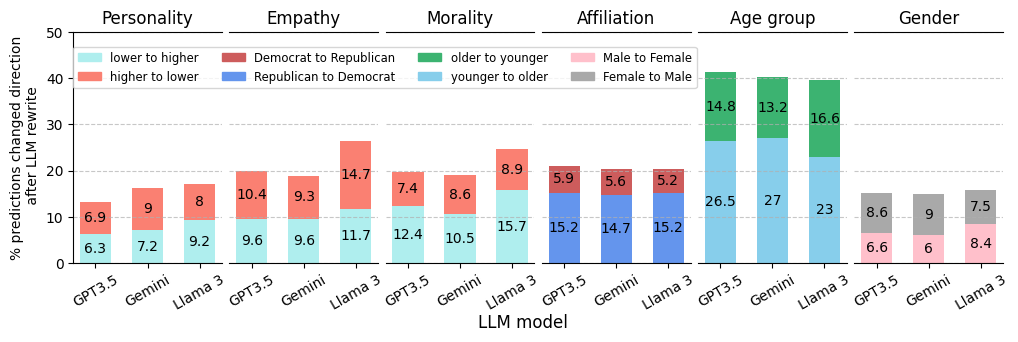

In [111]:
import warnings

warnings.filterwarnings("ignore")

dataset_to_values_dict = {
    "essays": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "facebook": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "wassa": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "gender": {"higher": "Male to Female", "lower": "Female to Male"},
    "party": {
        "higher": "Republican to Democrat",
        "lower": "Democrat to Republican",
    },
    "cohort": {"higher": "younger to older", "lower": "older to younger"},
}


metric_to_color = {
    "lower to higher": "paleturquoise",
    "higher to lower": "salmon",
    "Democrat to Republican": "indianred",
    "Republican to Democrat": "cornflowerblue",
    "older to younger": "mediumseagreen",
    "younger to older": "skyblue",
    "Male to Female": "pink",
    "Female to Male": "darkgrey",
}


def show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df):
    df_to_work_on = diff_in_predicted_labels_df.copy()

    df_to_work_on["unchanged"] = df_to_work_on["unchanged"].apply(lambda x: np.mean(x))
    df_to_work_on["higher"] = df_to_work_on["higher"].apply(lambda x: np.mean(x))
    df_to_work_on["lower"] = df_to_work_on["lower"].apply(lambda x: np.mean(x))

    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12, 3), sharey=True)
    for index, (ax, dataset) in enumerate(
        zip(axs, ["essays", "wassa", "facebook", "party", "cohort", "gender"])
    ):
        sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
        sub_df = sub_df.drop(columns=["dataset"], axis=1)

        llm_models = ["gpt", "gemini", "llama"]
        llm_models_names = [LLM_TO_NAME[llm_model] for llm_model in llm_models]
        highers = [
            sub_df[sub_df["LLM_model"] == llm_model]["higher"].mean() * 100
            for llm_model in llm_models
        ]
        lowers = [
            sub_df[sub_df["LLM_model"] == llm_model]["lower"].mean() * 100
            for llm_model in llm_models
        ]
        values_dict = {
            dataset_to_values_dict[dataset]["higher"]: highers,
            dataset_to_values_dict[dataset]["lower"]: lowers,
        }
        width = 0.6

        bottom = np.zeros(len(llm_models_names))

        for key, val_count in values_dict.items():
            val_count = np.round(val_count, 1)
            p = ax.bar(
                llm_models_names,
                val_count,
                width,
                label=key,
                bottom=bottom,
                color=metric_to_color[key],
            )
            # rotate the x labels by 30 degrees
            ax.set_xticklabels(llm_models_names, rotation=30)
            bottom += val_count

            ax.bar_label(p, label_type="center")
            ax.set_ylim(0, 50)

        ax.set_title(DATASET_TO_NAME[dataset])
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        if index == 0:
            ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
            # ax.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=2)
            # ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        else:
            # remove the yticks
            ax.yaxis.set_ticks_position("none")
            # remove the top and right spines
            # ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(False)
    # get the legend of the first axis and legend it on fig
    handles = [
        mpatches.Patch(color=metric_to_color[key], label=key)
        for key in metric_to_color.keys()
    ]
    labels = [key for key in metric_to_color.keys()]
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.12, 0.85),
        ncol=4,
        fontsize="small",
    )
    fig.subplots_adjust(wspace=0.05)
    fig.supxlabel("LLM model", y=-0.12)
    plt.savefig(
        f"figures/difference_in_predicted_labels_agg_for_appendix_different_llms.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df)

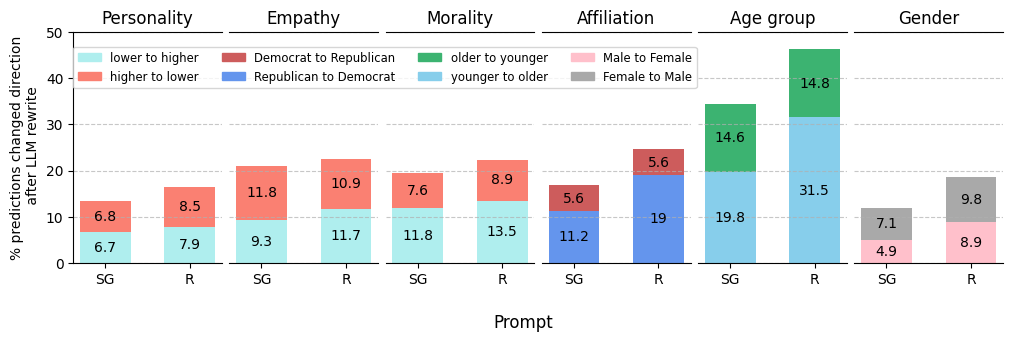

In [112]:
import warnings

warnings.filterwarnings("ignore")

dataset_to_values_dict = {
    "essays": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "facebook": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "wassa": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "gender": {"higher": "Male to Female", "lower": "Female to Male"},
    "party": {
        "higher": "Republican to Democrat",
        "lower": "Democrat to Republican",
    },
    "cohort": {"higher": "younger to older", "lower": "older to younger"},
}


metric_to_color = {
    "lower to higher": "paleturquoise",
    "higher to lower": "salmon",
    "Democrat to Republican": "indianred",
    "Republican to Democrat": "cornflowerblue",
    "older to younger": "mediumseagreen",
    "younger to older": "skyblue",
    "Male to Female": "pink",
    "Female to Male": "darkgrey",
}


def show_the_specific_mistakes_models_make_agg_prompts(
    diff_in_predicted_labels_df_with_prompts,
):
    df_to_work_on = diff_in_predicted_labels_df_with_prompts.copy()

    df_to_work_on["unchanged"] = df_to_work_on["unchanged"].apply(lambda x: np.mean(x))
    df_to_work_on["higher"] = df_to_work_on["higher"].apply(lambda x: np.mean(x))
    df_to_work_on["lower"] = df_to_work_on["lower"].apply(lambda x: np.mean(x))

    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12, 3), sharey=True)
    for index, (ax, dataset) in enumerate(
        zip(axs, ["essays", "wassa", "facebook", "party", "cohort", "gender"])
    ):
        sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
        sub_df = sub_df.drop(columns=["dataset"], axis=1)

        prompts = ["syntax_grammar", "rephrase"]
        prompt_names = ["SG", "R"]
        highers = [
            sub_df[sub_df["prompt"] == prompt]["higher"].mean() * 100
            for prompt in prompts
        ]
        lowers = [
            sub_df[sub_df["prompt"] == prompt]["lower"].mean() * 100
            for prompt in prompts
        ]
        values_dict = {
            dataset_to_values_dict[dataset]["higher"]: highers,
            dataset_to_values_dict[dataset]["lower"]: lowers,
        }
        width = 0.6

        bottom = np.zeros(len(prompt_names))

        for key, val_count in values_dict.items():
            val_count = np.round(val_count, 1)
            p = ax.bar(
                prompt_names,
                val_count,
                width,
                label=key,
                bottom=bottom,
                color=metric_to_color[key],
            )
            # rotate the x labels by 30 degrees
            ax.set_xticklabels(prompt_names)
            bottom += val_count

            ax.bar_label(p, label_type="center")
            ax.set_ylim(0, 50)

        ax.set_title(DATASET_TO_NAME[dataset])
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        if index == 0:
            ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
            # ax.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=2)
            # ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        else:
            # remove the yticks
            ax.yaxis.set_ticks_position("none")
            # remove the top and right spines
            # ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(False)
    # get the legend of the first axis and legend it on fig
    handles = [
        mpatches.Patch(color=metric_to_color[key], label=key)
        for key in metric_to_color.keys()
    ]
    labels = [key for key in metric_to_color.keys()]
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.12, 0.85),
        ncol=4,
        fontsize="small",
    )
    fig.subplots_adjust(wspace=0.05)
    fig.supxlabel("Prompt", y=-0.12)
    plt.savefig(
        f"figures/difference_in_predicted_labels_agg_for_appendix_different_prompts.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_the_specific_mistakes_models_make_agg_prompts(
    diff_in_predicted_labels_df_with_prompts
)

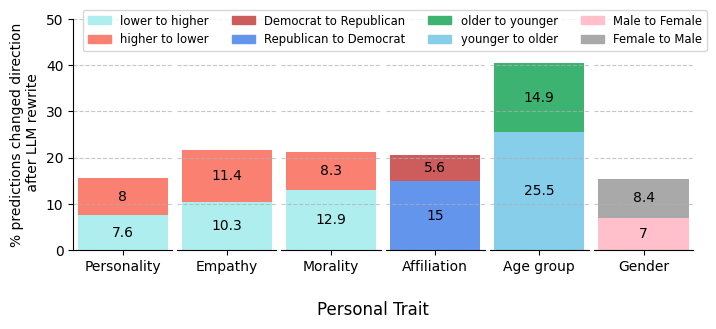

In [113]:
import warnings

warnings.filterwarnings("ignore")

dataset_to_values_dict = {
    "essays": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "facebook": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "wassa": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "gender": {"higher": "Male to Female", "lower": "Female to Male"},
    "party": {
        "higher": "Republican to Democrat",
        "lower": "Democrat to Republican",
    },
    "cohort": {"higher": "younger to older", "lower": "older to younger"},
}


metric_to_color = {
    "lower to higher": "paleturquoise",
    "higher to lower": "salmon",
    "Democrat to Republican": "indianred",
    "Republican to Democrat": "cornflowerblue",
    "older to younger": "mediumseagreen",
    "younger to older": "skyblue",
    "Male to Female": "pink",
    "Female to Male": "darkgrey",
}


def show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df):
    df_to_work_on = diff_in_predicted_labels_df.copy()

    df_to_work_on["unchanged"] = df_to_work_on["unchanged"].apply(lambda x: np.mean(x))
    df_to_work_on["higher"] = df_to_work_on["higher"].apply(lambda x: np.mean(x))
    df_to_work_on["lower"] = df_to_work_on["lower"].apply(lambda x: np.mean(x))

    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(8, 3), sharey=True)
    for index, (ax, dataset) in enumerate(
        zip(axs, ["essays", "wassa", "facebook", "party", "cohort", "gender"])
    ):
        sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
        sub_df = sub_df.drop(columns=["dataset"], axis=1)

        llm_models = ["gpt", "gemini", "llama"]
        llm_models_names = [LLM_TO_NAME[llm_model] for llm_model in llm_models]
        highers = [
            sub_df[sub_df["LLM_model"] == llm_model]["higher"].mean() * 100
            for llm_model in llm_models
        ]
        lowers = [
            sub_df[sub_df["LLM_model"] == llm_model]["lower"].mean() * 100
            for llm_model in llm_models
        ]
        values_dict = {
            dataset_to_values_dict[dataset]["higher"]: np.mean(highers),
            dataset_to_values_dict[dataset]["lower"]: np.mean(lowers),
        }
        width = 0.1

        bottom = np.zeros(1)

        for key, val_count in values_dict.items():
            val_count = np.round(val_count, 1)
            p = ax.bar(
                DATASET_TO_NAME[dataset],
                val_count,
                width,
                label=key,
                bottom=bottom,
                color=metric_to_color[key],
            )
            # rotate the x labels by 30 degrees
            ax.set_xticklabels([DATASET_TO_NAME[dataset]], rotation=0)
            bottom += val_count

            ax.bar_label(p, label_type="center")
            ax.set_ylim(0, 50)

        # ax.set_title()
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        # remove the x ticks and only keep the label
        if index == 0:
            ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
            # ax.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=2)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        else:
            # remove the yticks
            ax.yaxis.set_ticks_position("none")
            # remove the top and right spines
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(False)
    # get the legend of the first axis and legend it on fig
    handles = [
        mpatches.Patch(color=metric_to_color[key], label=key)
        for key in metric_to_color.keys()
    ]
    labels = [key for key in metric_to_color.keys()]
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.13, 0.93),
        ncol=4,
        fontsize="small",
    )
    fig.subplots_adjust(wspace=0.05)
    fig.supxlabel("Personal Trait", y=-0.12)
    plt.savefig(
        f"figures/difference_in_predicted_labels_agg.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df)

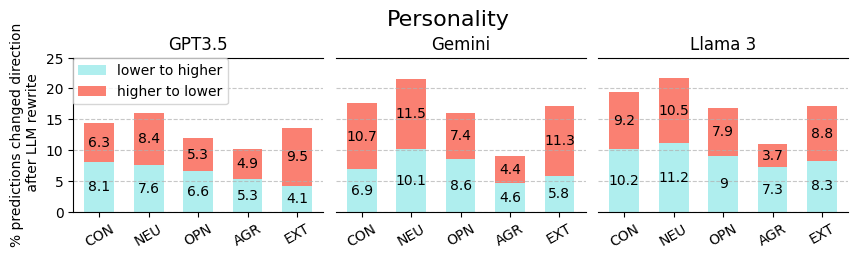

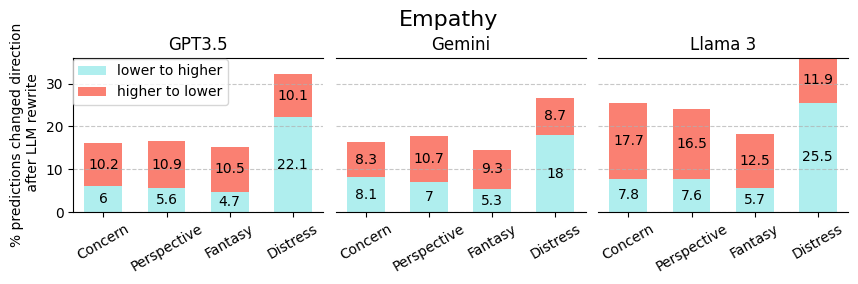

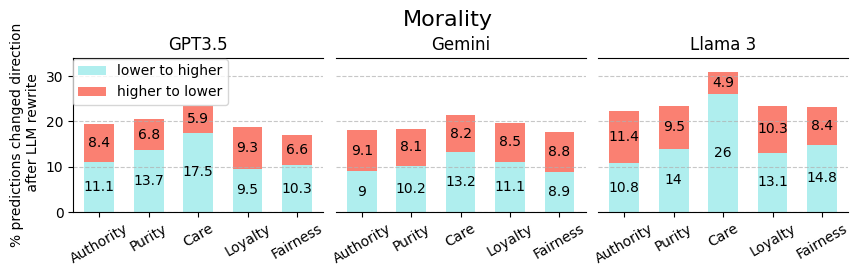

In [114]:
def show_the_specific_mistakes_models_make(diff_in_predicted_labels_df):
    df_to_work_on = diff_in_predicted_labels_df.copy()

    df_to_work_on["unchanged"] = df_to_work_on["unchanged"].apply(lambda x: np.mean(x))
    df_to_work_on["higher"] = df_to_work_on["higher"].apply(lambda x: np.mean(x))
    df_to_work_on["lower"] = df_to_work_on["lower"].apply(lambda x: np.mean(x))

    for dataset in ["essays", "wassa", "facebook"]:
        sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
        sub_df = sub_df.drop(columns=["dataset"], axis=1)
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10.0, 2), sharey=True)
        for index, (ax, llm_model) in enumerate(zip(axs, ["gpt", "gemini", "llama"])):
            x = sub_df[sub_df["LLM_model"] == llm_model].copy()
            x = x.drop(columns=["LLM_model"], axis=1)
            categories = x["label"].tolist()
            categories = [LABELS_TO_NAME[cat] for cat in categories]
            highers = np.array(x["higher"].tolist()) * 100
            lowers = np.array(x["lower"].tolist()) * 100
            values_dict = {
                "lower to higher": highers,
                "higher to lower": lowers,
            }
            values_colors = {
                "higher to lower": "salmon",
                "lower to higher": "paleturquoise",
            }
            width = 0.6

            bottom = np.zeros(len(categories))

            for key, val_count in values_dict.items():
                val_count = np.round(val_count, 1)
                p = ax.bar(
                    categories,
                    val_count,
                    width,
                    label=key,
                    bottom=bottom,
                    color=values_colors[key],
                )
                # rotate the x labels by 30 degrees
                ax.set_xticklabels(categories, rotation=30)
                bottom += val_count

                ax.bar_label(p, label_type="center")
                if dataset == "essays":
                    ax.set_ylim(0, 25)
                elif dataset == "wassa":
                    ax.set_ylim(0, 36)
                elif dataset == "facebook":
                    ax.set_ylim(0, 34)
                else:
                    raise ValueError("Unknown dataset")

            ax.set_title(
                LLM_TO_NAME[llm_model],
            )
            ax.grid(axis="y", linestyle="--", alpha=0.7)
            if index == 0:
                ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
                ax.legend(loc="upper left", bbox_to_anchor=(-0.03, 1.04), ncol=1)
                # ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
            else:
                # remove the yticks
                ax.yaxis.set_ticks_position("none")
                # remove the top and right spines
                # ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["left"].set_visible(False)
        fig.suptitle(f"{DATASET_TO_NAME[dataset]}", fontsize=16, y=1.12)
        fig.subplots_adjust(wspace=0.05)
        plt.savefig(
            f"figures/difference_in_predicted_labels_{dataset}.png",
            bbox_inches="tight",
            dpi=300,
        )
        plt.show()


show_the_specific_mistakes_models_make(diff_in_predicted_labels_df)

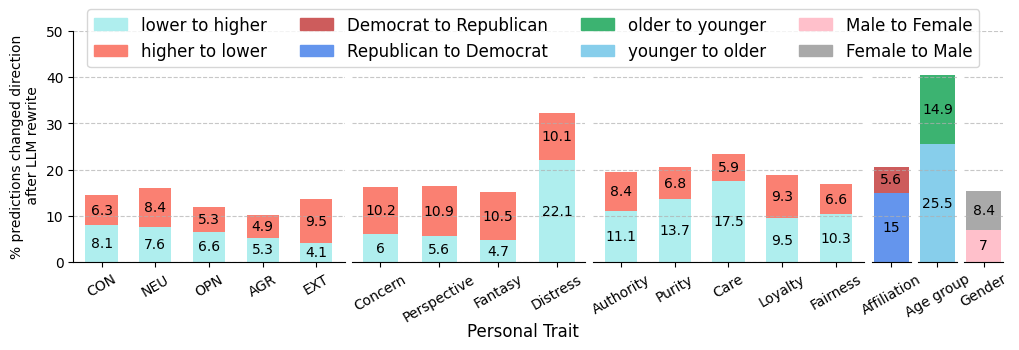

In [115]:
import warnings

warnings.filterwarnings("ignore")

dataset_to_values_dict = {
    "essays": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "facebook": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "wassa": {
        "higher": "lower to higher",
        "lower": "higher to lower",
    },
    "gender": {"higher": "Male to Female", "lower": "Female to Male"},
    "party": {
        "higher": "Republican to Democrat",
        "lower": "Democrat to Republican",
    },
    "cohort": {"higher": "younger to older", "lower": "older to younger"},
}


metric_to_color = {
    "lower to higher": "paleturquoise",
    "higher to lower": "salmon",
    "Democrat to Republican": "indianred",
    "Republican to Democrat": "cornflowerblue",
    "older to younger": "mediumseagreen",
    "younger to older": "skyblue",
    "Male to Female": "pink",
    "Female to Male": "darkgrey",
}


def show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df):
    df_to_work_on = diff_in_predicted_labels_df.copy()

    df_to_work_on["unchanged"] = df_to_work_on["unchanged"].apply(lambda x: np.mean(x))
    df_to_work_on["higher"] = df_to_work_on["higher"].apply(lambda x: np.mean(x))
    df_to_work_on["lower"] = df_to_work_on["lower"].apply(lambda x: np.mean(x))

    fig, axs = plt.subplots(
        nrows=1, ncols=6, figsize=(12, 3), sharey=True, width_ratios=[7, 6, 7, 1, 1, 1]
    )
    for index, (ax, dataset) in enumerate(
        zip(axs, ["essays", "wassa", "facebook", "party", "cohort", "gender"])
    ):
        if dataset in ["essays", "wassa", "facebook"]:
            sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
            sub_df = sub_df.drop(columns=["dataset"], axis=1)
            x = sub_df[sub_df["LLM_model"] == "gpt"].copy()
            x = x.drop(columns=["LLM_model"], axis=1)
            categories = x["label"].tolist()
            categories = [LABELS_TO_NAME[cat] for cat in categories]
            highers = np.array(x["higher"].tolist()) * 100
            lowers = np.array(x["lower"].tolist()) * 100
            values_dict = {
                "lower to higher": highers,
                "higher to lower": lowers,
            }
            values_colors = {
                "higher to lower": "salmon",
                "lower to higher": "paleturquoise",
            }
            width = 0.6

            bottom = np.zeros(len(categories))

            for key, val_count in values_dict.items():
                val_count = np.round(val_count, 1)
                p = ax.bar(
                    categories,
                    val_count,
                    width,
                    label=key,
                    bottom=bottom,
                    color=values_colors[key],
                )
                # rotate the x labels by 30 degrees
                ax.set_xticklabels(categories, rotation=30)
                bottom += val_count

                ax.bar_label(p, label_type="center")
                if dataset == "essays":
                    ax.set_ylim(0, 25)
                elif dataset == "wassa":
                    ax.set_ylim(0, 36)
                elif dataset == "facebook":
                    ax.set_ylim(0, 34)
                else:
                    raise ValueError("Unknown dataset")

            ax.grid(axis="y", linestyle="--", alpha=0.7)
            # remove the right and top spines
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            if index == 0:
                ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
            if index > 0:
                ax.spines["left"].set_visible(False)
                ax.yaxis.set_ticks_position("none")
        else:
            sub_df = df_to_work_on[df_to_work_on["dataset"] == dataset].copy()
            sub_df = sub_df.drop(columns=["dataset"], axis=1)

            llm_models = ["gpt", "gemini", "llama"]
            highers = [
                sub_df[sub_df["LLM_model"] == llm_model]["higher"].mean() * 100
                for llm_model in llm_models
            ]
            lowers = [
                sub_df[sub_df["LLM_model"] == llm_model]["lower"].mean() * 100
                for llm_model in llm_models
            ]
            values_dict = {
                dataset_to_values_dict[dataset]["higher"]: np.mean(highers),
                dataset_to_values_dict[dataset]["lower"]: np.mean(lowers),
            }
            width = 0.1

            bottom = np.zeros(1)

            for key, val_count in values_dict.items():
                val_count = np.round(val_count, 1)
                p = ax.bar(
                    DATASET_TO_NAME[dataset],
                    val_count,
                    width,
                    label=key,
                    bottom=bottom,
                    color=metric_to_color[key],
                )
                # rotate the x labels by 30 degrees
                ax.set_xticklabels([DATASET_TO_NAME[dataset]], rotation=30)
                bottom += val_count

                ax.bar_label(p, label_type="center")
                ax.set_ylim(0, 50)

            # ax.set_title()
            ax.grid(axis="y", linestyle="--", alpha=0.7)
            # remove the x ticks and only keep the label
            if index == 0:
                ax.set_ylabel("% predictions changed direction\n after LLM rewrite")
                # ax.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=2)
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
            else:
                # remove the yticks
                ax.yaxis.set_ticks_position("none")
                # remove the top and right spines
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["left"].set_visible(False)
    # get the legend of the first axis and legend it on fig
    handles = [
        mpatches.Patch(color=metric_to_color[key], label=key)
        for key in metric_to_color.keys()
    ]
    labels = [key for key in metric_to_color.keys()]
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.13, 0.98),
        ncol=4,
        fontsize="large",
    )
    fig.subplots_adjust(wspace=0.05)
    fig.supxlabel("Personal Trait", y=-0.15)
    plt.savefig(
        f"figures/difference_in_predicted_labels_agg.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()


show_the_specific_mistakes_models_make_agg(diff_in_predicted_labels_df)

## Detecting any Signal that can be used for classification in rewritten text

In [116]:
def get_diff_from_reversed_training(df):

    df_to_work_on = df.copy()

    all_datasets = []
    all_labels = []
    all_llm_models = []
    all_model_types = []
    all_features = []
    all_rewritten_types = []
    model_original_performance = []
    model_reversed_performance = []
    p_values = []

    for dataset in df_to_work_on["dataset"].unique():
        for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
            "label"
        ].unique():
            for llm_model in df_to_work_on["LLM_model"].unique():
                for model_type in df_to_work_on["model_type"].unique():
                    for feature in df_to_work_on["feature"].unique():
                        for rewritten_type in df_to_work_on["rewritten_type"].unique():
                            if (
                                feature == "longformer" and model_type != "longformer"
                            ) or (
                                model_type == "longformer" and feature != "longformer"
                            ):
                                continue

                            sub_df = df_to_work_on[
                                (df_to_work_on["dataset"] == dataset)
                                & (df_to_work_on["label"] == label)
                                & (df_to_work_on["LLM_model"] == llm_model)
                                & (df_to_work_on["model_type"] == model_type)
                                & (df_to_work_on["feature"] == feature)
                                & (df_to_work_on["rewritten_type"] == rewritten_type)
                            ].copy()

                            all_datasets.append(dataset)
                            all_labels.append(label)
                            all_llm_models.append(llm_model)
                            all_model_types.append(model_type)
                            all_features.append(feature)
                            all_rewritten_types.append(rewritten_type)
                            model_original_performance.append(
                                sub_df[sub_df["reverse"] == 0][
                                    "best_results_on_test"
                                ].mean()
                            )
                            model_reversed_performance.append(
                                sub_df[sub_df["reverse"] == 1][
                                    "best_results_on_test"
                                ].mean()
                            )

                            _, p_value = stats.ttest_ind(
                                sub_df[sub_df["reverse"] == 0]["best_results_on_test"],
                                sub_df[sub_df["reverse"] == 1]["best_results_on_test"],
                            )
                            p_values.append(p_value)

    diff_results_df = pd.DataFrame(
        {
            "dataset": all_datasets,
            "label": all_labels,
            "LLM_model": all_llm_models,
            "model_type": all_model_types,
            "feature": all_features,
            "rewritten_type": all_rewritten_types,
            "model_original_performance": model_original_performance,
            "model_reversed_performance": model_reversed_performance,
            "p_value": p_values,
        }
    )
    diff_results_df["is_reverse_higher"] = (
        diff_results_df["model_reversed_performance"]
        > diff_results_df["model_original_performance"]
    )
    return diff_results_df

In [117]:
diff_reversed_df = get_diff_from_reversed_training(df)
diff_reversed_df.head(3)

,dataset,label,LLM_model,model_type,feature,rewritten_type,model_original_performance,model_reversed_performance,p_value,is_reverse_higher
0,essays,CON,gemini,gradient_boosting,tfidf,rephrase,0.661829,0.648053,0.751973,False
1,essays,CON,gemini,gradient_boosting,tfidf,syntax_grammar,0.683495,0.658761,0.601724,False
2,essays,CON,gemini,gradient_boosting,openai,rephrase,0.699093,0.656673,0.543607,False


In [118]:
def get_reversed_summarized_df(diff_reversed_df):

    df_to_work_on = diff_reversed_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    all_datasets = []
    all_llm_models = []
    all_original_values = []
    all_reversed_values = []
    all_perc_unchanged = []
    all_perc_higher = []
    all_perc_lower = []

    for dataset in ["essays", "wassa", "facebook", "cohort", "party", "gender"]:
        for llm_model in ["gpt", "llama", "gemini"]:
            sub_df = df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == llm_model)
            ].copy()
            sub_df.dropna(inplace=True)

            threshold_level = 0.05 / sub_df.shape[0]
            sub_df["is_difference_significant"] = sub_df.apply(
                lambda row: row["p_value"] < threshold_level, axis=1
            )
            all_datasets.append(dataset)
            all_llm_models.append(llm_model)

            all_original_values.append(sub_df["model_original_performance"].mean())
            all_reversed_values.append(sub_df["model_reversed_performance"].mean())

            all_perc_unchanged.append(
                sub_df[sub_df["is_difference_significant"] == False].shape[0]
                / sub_df.shape[0]
                * 100
            )
            all_perc_higher.append(
                sub_df[
                    (sub_df["is_difference_significant"] == True)
                    & (sub_df["is_reverse_higher"] == True)
                ].shape[0]
                / sub_df.shape[0]
                * 100
            )
            all_perc_lower.append(
                sub_df[
                    (sub_df["is_difference_significant"] == True)
                    & (sub_df["is_reverse_higher"] == False)
                ].shape[0]
                / sub_df.shape[0]
                * 100
            )

    reversed_results_df = pd.DataFrame(
        {
            "dataset": all_datasets,
            "LLM_model": all_llm_models,
            "original_values": all_original_values,
            "reversed_values": all_reversed_values,
            "perc_unchanged": all_perc_unchanged,
            "perc_higher": all_perc_higher,
            "perc_lower": all_perc_lower,
        }
    )
    return reversed_results_df

In [119]:
reversed_results_df = get_reversed_summarized_df(diff_reversed_df)
reversed_results_df

,dataset,LLM_model,original_values,reversed_values,perc_unchanged,perc_higher,perc_lower
0,essays,gpt,0.631435,0.611848,91.666667,0.000000,8.333333
1,essays,llama,0.667085,0.615726,100.000000,0.000000,0.000000
2,essays,gemini,0.677334,0.611550,95.000000,0.000000,5.000000
3,wassa,gpt,0.653714,0.658736,98.000000,2.000000,0.000000
4,wassa,llama,0.655645,0.658578,96.078431,3.921569,0.000000
5,wassa,gemini,0.654811,0.655312,96.000000,0.000000,4.000000
6,facebook,gpt,0.637029,0.572779,94.915254,0.000000,5.084746
7,facebook,llama,0.639069,0.577479,87.755102,2.040816,10.204082
8,facebook,gemini,0.624112,0.568475,100.000000,0.000000,0.000000
9,cohort,gpt,0.360480,0.296344,90.000000,0.000000,10.000000


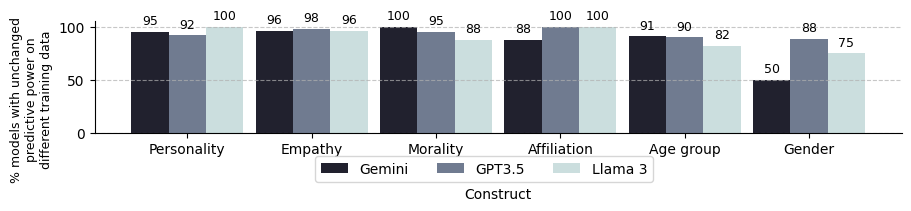

In [120]:
def show_the_comparison_between_reverse_modes(diff_reversed_df):

    df_to_work_on = diff_reversed_df.copy()
    dataset_categories = ["essays", "wassa", "facebook", "party", "cohort", "gender"]

    results_per_model_dict = {
        "gemini": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gemini")
            ]["perc_unchanged"].values[0]
            for dataset in dataset_categories
        ],
        "gpt": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gpt")
            ]["perc_unchanged"].values[0]
            for dataset in dataset_categories
        ],
        "llama": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "llama")
            ]["perc_unchanged"].values[0]
            for dataset in dataset_categories
        ],
        # "original": [
        #     df_to_work_on[df_to_work_on["dataset"] == dataset]["original_values"].mean()
        #     * 100
        #     for dataset in dataset_categories
        # ],
    }

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(9, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 3))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 2),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3, fmt="%.0f", fontsize=9)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(
        "% models with unchanged\npredictive power on\ndifferent training data",
        fontsize=9,
        y=0.3,
    )
    # ax.set_ylabel("% predictions unchanged\n after rewrite", labelpad=-3)
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width,
        labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories],
    )
    ax.legend(loc="upper right", ncols=1)
    # ax.set_ylim(45, 70)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.70, -0.15))
    plt.xlabel("Construct", labelpad=22)

    plt.savefig(
        "figures/effect_of_different_training_data_ratio.png",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()


show_the_comparison_between_reverse_modes(reversed_results_df)

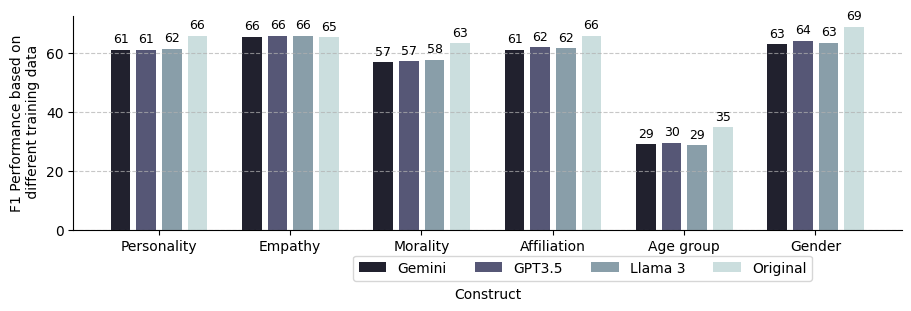

In [121]:
def show_the_comparison_between_reverse_modes(reversed_results_df):

    df_to_work_on = reversed_results_df.copy()
    dataset_categories = ["essays", "wassa", "facebook", "party", "cohort", "gender"]

    results_per_model_dict = {
        "gemini": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gemini")
            ]["reversed_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "gpt": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "gpt")
            ]["reversed_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "llama": [
            df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["LLM_model"] == "llama")
            ]["reversed_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
        "original": [
            df_to_work_on[df_to_work_on["dataset"] == dataset]["original_values"].mean()
            * 100
            for dataset in dataset_categories
        ],
    }

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    multiplier_for_starts = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(9, 3))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 4))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier_for_starts
        rects = ax.bar(
            x + offset,
            np.round(measurement, 2),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[int(multiplier)],
        )
        ax.bar_label(rects, padding=3, fmt="%.0f", fontsize=9)
        multiplier += 1
        multiplier_for_starts += 1 + 0.3

    # for index, dataset in enumerate(dataset_categories):
    #     # draw a baseline horizontal line
    #     ax.axhline(
    #         xmin=0.35 * index,
    #         xmax=0.35 * (index + 1) - 0.03,
    #         y=DATASET_TO_BASELINES[dataset] * 100,
    #         color="black",
    #         linestyle="--",
    #         alpha=0.7,
    #         linewidth=0.8,
    #     )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("F1 Performance based on\n different training data")
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(
        x + width + 0.14,
        labels=[DATASET_TO_NAME[dataset] for dataset in dataset_categories],
    )
    ax.legend(loc="upper right", ncols=1)
    # ax.set_ylim(45, 70)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(loc="lower right", bbox_to_anchor=(0.9, -0.27), ncol=4)
    plt.xlabel("Construct", labelpad=24)

    plt.savefig(
        "figures/effect_of_different_training_data.png", bbox_inches="tight", dpi=300
    )

    plt.show()


show_the_comparison_between_reverse_modes(reversed_results_df)

## Effect of Data Size

In [122]:
def read_data_from_wassa_individual():
    full_names = []
    datasets = []
    LLM_models = []
    label_columns = []
    model_types = []
    features = []
    output_types = []
    reverses = []
    rewritten_types = []
    random_seeds = []
    best_results = []
    best_results_on_test = []
    best_results_on_rewritten = []

    dataset = "wassa_individual"
    directory = "wassa_individual_logs"
    print("length of directory: ", len(os.listdir(directory)))

    for file in os.listdir(directory):

        if not file.endswith(".log") or not "random_seed" in file:
            continue
        with open(os.path.join(directory, file)) as f:
            data = f.readlines()

        (
            llm_model,
            label,
            model_type,
            feature,
            output_type,
            reversed,
            rewritten_type,
            random_seed,
        ) = parse_file(file)

        best_results_found = False
        best_results_on_test_found = False
        best_results_rewritten_found = False

        for index, line in enumerate(data):
            if line.startswith("best score:"):
                best_results.append(float(data[index + 1].strip()))
                best_results_found = True
            if line.startswith("best score on test essays"):
                best_results_on_test.append(float(data[index + 1].strip()))
                best_results_on_test_found = True
            if line.startswith("best score on rewritten essays"):
                best_results_on_rewritten.append(float(data[index + 1].strip()))
                best_results_rewritten_found = True

        if best_results_rewritten_found == False:
            if reversed == 2:
                best_results_on_rewritten.append(np.nan)
            else:
                print("error")
                print(file)
                continue
        if best_results_on_test_found == False or best_results_found == False:
            print("error")
            print(file)

            continue

        datasets.append(dataset)
        LLM_models.append(llm_model)
        label_columns.append(label)
        model_types.append(model_type)
        features.append(feature)
        output_types.append(output_type)
        reverses.append(reversed)
        rewritten_types.append(rewritten_type)
        random_seeds.append(random_seed)
        full_names.append(file)

    df = pd.DataFrame(
        {
            "file_name": full_names,
            "dataset": datasets,
            "LLM_model": LLM_models,
            "label": label_columns,
            "model_type": model_types,
            "feature": features,
            "output_type": output_types,
            "reverse": reverses,
            "rewritten_type": rewritten_types,
            "random_seed": random_seeds,
            "best_results": best_results,
            "best_results_on_test": best_results_on_test,
            "best_results_on_rewritten": best_results_on_rewritten,
        }
    )

    df = df[df["output_type"] == "classification"]
    df = df.drop(columns=["output_type"], axis=1)

    df["rewritten_type_str"] = df["rewritten_type"]
    df["rewritten_type"] = df["rewritten_type"].replace(
        {
            "syntax_grammar_llama_cleaned": "syntax_grammar",
            "rephrase_llama_cleaned": "rephrase",
            "syntax_grammar_llama": "syntax_grammar",
            "syntax_grammar_gemini_cleaned": "syntax_grammar",
            "rephrase_gpt": "rephrase",
            "rephrase_gemini_cleaned": "rephrase",
            "rephrase_gemini": "rephrase",
            "syntax_grammar_gpt": "syntax_grammar",
            "rephrase_llama": "rephrase",
            "syntax_grammar_gemini": "syntax_grammar",
        }
    )
    df["baseline"] = df["label"].map(BASELINES)

    def filter_bad_df(row):
        if row["best_results_on_test"] < row["baseline"]:
            return True
        return False

    df["drop"] = df.apply(filter_bad_df, axis=1)

    print(df.shape)
    df = df[df["drop"] == False]
    print(df.shape)

    return df

In [123]:
wassa_individual_df = read_data_from_wassa_individual()
wassa_individual_results_df = get_results_with_diffs(wassa_individual_df)
wassa_results_df = results_df[results_df["dataset"] == "wassa"]
wassa_combined_df = pd.concat([wassa_individual_results_df, wassa_results_df])

length of directory:  56164
(28082, 15)
(21762, 15)


In [124]:
wassa_combined_df.head(3)

,dataset,model,feature,LLM_model,label,rewritten_type,main_model_on_org,main_model_on_rewritten,p_value,main_model_on_rewritten_higher
0,wassa_individual,random_forest,openai,gpt,.iri.perspective,rephrase,0.652949,0.581522,1.495178e-15,False
1,wassa_individual,random_forest,tfidf,gpt,.iri.perspective,rephrase,0.667645,0.474631,2.972207e-25,False
2,wassa_individual,svm,openai,gpt,.iri.perspective,rephrase,0.769510,0.622097,1.043057e-29,False


dataset        wassa  wassa_individual
LLM_model                             
gemini     68.000000         12.500000
gpt        70.000000          8.333333
llama      54.901961         11.111111


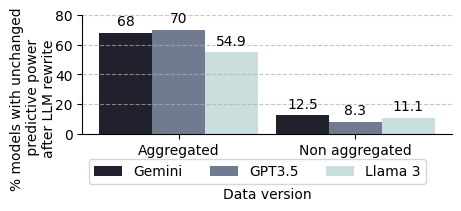

In [125]:
def show_the_comparison_between_wassa(results_df):

    df_to_work_on = results_df.copy()
    df_to_work_on.dropna(subset=["p_value"], inplace=True)

    significance_thresholds = dict(
        zip(
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().index.tolist(),
            df_to_work_on.groupby(["dataset", "LLM_model"]).size().values.tolist(),
        )
    )
    df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
        lambda row: row["p_value"]
        < 0.05 / significance_thresholds[(row["dataset"], row["LLM_model"])],
        axis=1,
    )

    results_per_model = (
        df_to_work_on.groupby(["dataset", "LLM_model"])[
            "main_model_on_rewritten_significance"
        ].value_counts(normalize=True)
        * 100
    )

    results_per_model = results_per_model[:, :, False].unstack(level=0)
    print(results_per_model)
    dataset_categories = results_per_model.columns

    results_per_model_dict = dict(
        zip(results_per_model.index, results_per_model.values.tolist())
    )

    x = np.arange(len(dataset_categories))  # the label locations
    width = 0.30  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(4.5, 2))
    color_pallete = "bone"
    colors = plt.get_cmap(color_pallete)(np.linspace(0.15, 0.85, 3))

    for attribute, measurement in results_per_model_dict.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            np.round(measurement, 1),
            width,
            label=LLM_TO_NAME[attribute],
            color=colors[multiplier],
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(
        "% models with unchanged\n predictive power\nafter LLM rewrite",
        labelpad=-1,
        y=0.3,
    )
    # ax.set_title(
    #     "Change in the performance after rewriting by LLMs", position=(0.5, 1.1), pad=10
    # )
    ax.set_xticks(x + width, labels=["Aggregated", "Non aggregated"])
    ax.legend(loc="upper right", ncols=3, bbox_to_anchor=(0.95, -0.15))
    ax.set_ylim(0, 80)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel("Data version", labelpad=21)

    plt.savefig("figures/wassa_combined_diff.png", bbox_inches="tight", dpi=300)

    plt.show()


show_the_comparison_between_wassa(wassa_combined_df)

In [126]:
df_to_work_on = wassa_combined_df.copy()
df_to_work_on.dropna(subset=["p_value"], inplace=True)

significance_thresholds = dict(
    zip(
        df_to_work_on.groupby(["dataset", "LLM_model"]).size().index.tolist(),
        df_to_work_on.groupby(["dataset", "LLM_model"]).size().values.tolist(),
    )
)
df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on.apply(
    lambda row: row["p_value"]
    < 0.05 / significance_thresholds[(row["dataset"], row["LLM_model"])],
    axis=1,
)

df_to_work_on["main_model_on_rewritten_significance"] = df_to_work_on[
    "main_model_on_rewritten_significance"
].astype(int)

In [127]:
df_to_work_on.head(3)

,dataset,model,feature,LLM_model,label,rewritten_type,main_model_on_org,main_model_on_rewritten,p_value,main_model_on_rewritten_higher,main_model_on_rewritten_significance
0,wassa_individual,random_forest,openai,gpt,.iri.perspective,rephrase,0.652949,0.581522,1.495178e-15,False,1
1,wassa_individual,random_forest,tfidf,gpt,.iri.perspective,rephrase,0.667645,0.474631,2.972207e-25,False,1
2,wassa_individual,svm,openai,gpt,.iri.perspective,rephrase,0.769510,0.622097,1.043057e-29,False,1


In [128]:
df_to_work_on_wassa = (
    df_to_work_on[df_to_work_on["dataset"] == "wassa"]
    .drop(
        [
            "dataset",
            "main_model_on_org",
            "main_model_on_rewritten",
            "main_model_on_rewritten_higher",
            "p_value",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": "wassa"})
)
df_to_work_on_wassa_individual = (
    df_to_work_on[df_to_work_on["dataset"] == "wassa_individual"]
    .drop(
        [
            "dataset",
            "main_model_on_org",
            "main_model_on_rewritten",
            "main_model_on_rewritten_higher",
            "p_value",
        ],
        axis=1,
    )
    .rename(columns={"main_model_on_rewritten_significance": "wassa_individual"})
)

merged_df = pd.merge(
    df_to_work_on_wassa,
    df_to_work_on_wassa_individual,
    on=[
        "LLM_model",
        "label",
        "model",
        "feature",
        "rewritten_type",
    ],
    how="inner",
)

In [129]:
a_positive_positive = merged_df[
    (merged_df["wassa"] == 1) & (merged_df["wassa_individual"] == 1)
].shape[0]

b_positive_negative = merged_df[
    (merged_df["wassa"] == 1) & (merged_df["wassa_individual"] == 0)
].shape[0]

c_negative_positive = merged_df[
    (merged_df["wassa"] == 0) & (merged_df["wassa_individual"] == 1)
].shape[0]

d_negative_negative = merged_df[
    (merged_df["wassa"] == 0) & (merged_df["wassa_individual"] == 0)
].shape[0]

contingency_table = np.array(
    [
        [a_positive_positive, b_positive_negative],
        [c_negative_positive, d_negative_negative],
    ]
)
print(contingency_table)

from statsmodels.stats.contingency_tables import mcnemar


print(mcnemar(contingency_table, exact=False, correction=False))

[[54  0]
 [91  6]]
pvalue      1.4367211464103852e-21
statistic   91.0


In [130]:
from collections import defaultdict


def get_the_changes_in_predictions_wassa_per_speaker_id(df):
    dataset = "wassa"
    wassa_main_df = pd.read_csv("../datasets/wassa_individual/clean_wassa.csv")
    selected_speaker_ids = [
        str(x) for x in wassa_main_df["speaker_id"].unique().tolist()
    ]

    df_to_work_on = df.copy()

    all_llm_models = []
    all_labels = []
    all_speaker_ids = []
    all_unchanged = []
    all_higher = []
    all_lower = []
    all_occs = []

    for llm_model in ["gpt", "gemini", "llama"]:
        for label in df_to_work_on[df_to_work_on["dataset"] == dataset][
            "label"
        ].unique():

            sub_df = df_to_work_on[
                (df_to_work_on["dataset"] == dataset)
                & (df_to_work_on["label"] == label)
                & (df_to_work_on["LLM_model"] == llm_model)
                & (df_to_work_on["reverse"] == 0)
            ].copy()

            agg_unchanged = defaultdict(int)
            agg_higher = defaultdict(int)
            agg_lower = defaultdict(int)
            agg_all = defaultdict(int)

            for _, row in sub_df.iterrows():
                try:
                    file_path = predictions_file_path.format(
                        row["LLM_model"],
                        row["label"],
                        row["model_type"],
                        row["feature"],
                        row["rewritten_type_str"],
                        row["random_seed"],
                    )
                    with open(os.path.join(f"{dataset}_logs", file_path)) as f:
                        json_data = json.load(f)
                except Exception as e:
                    print(e)
                    print(row["file_name"])

                all_ids, all_changes = get_changes_in_predictions_all(json_data)
                for _id, change in zip(all_ids, all_changes):
                    agg_all[_id] += 1
                    if change == "unchanged":
                        agg_unchanged[_id] += 1
                    elif change == "higher":
                        agg_higher[_id] += 1
                    else:
                        agg_lower[_id] += 1

            for key in selected_speaker_ids:
                all_speaker_ids.append(key)
                all_llm_models.append(llm_model)
                all_labels.append(label)
                all_unchanged.append(agg_unchanged[key])
                all_higher.append(agg_higher[key])
                all_lower.append(agg_lower[key])
                all_occs.append(agg_all[key])

    return pd.DataFrame(
        {
            "LLM_model": all_llm_models,
            "label": all_labels,
            "speaker_id": all_speaker_ids,
            "unchanged": all_unchanged,
            "higher": all_higher,
            "lower": all_lower,
            "occurrences": all_occs,
        }
    )


changes_in_predictions_wassa = get_the_changes_in_predictions_wassa_per_speaker_id(df)

[Errno 2] No such file or directory: 'wassa_logs/LLM_model=llama_label_column=.iri.distress_model_type=gradient_boosting_features=tfidf_output_type=classification_reverse=0_rewritten_type=syntax_grammar_random_seed=37467286.json'
LLM_model=llama_label_column=.iri.distress_model_type=gradient_boosting_features=tfidf_output_type=classification_reverse=0_rewritten_type=syntax_grammar_random_seed=37467286.log
[Errno 2] No such file or directory: 'wassa_logs/LLM_model=llama_label_column=.iri.distress_model_type=gradient_boosting_features=tfidf_output_type=classification_reverse=0_rewritten_type=syntax_grammar_random_seed=66613780.json'
LLM_model=llama_label_column=.iri.distress_model_type=gradient_boosting_features=tfidf_output_type=classification_reverse=0_rewritten_type=syntax_grammar_random_seed=66613780.log
[Errno 2] No such file or directory: 'wassa_logs/LLM_model=llama_label_column=.iri.distress_model_type=gradient_boosting_features=tfidf_output_type=classification_reverse=0_rewritten

In [131]:
changes_in_predictions_wassa

,LLM_model,label,speaker_id,unchanged,higher,lower,occurrences
0,gpt,.iri.concern,0,71,6,6,83
1,gpt,.iri.concern,1,70,4,8,82
2,gpt,.iri.concern,2,65,7,6,78
3,gpt,.iri.concern,3,82,8,7,97
4,gpt,.iri.concern,4,67,1,12,80
...,...,...,...,...,...,...,...
679,llama,.iri.distress,54,12,1,1,14
680,llama,.iri.distress,55,5,2,1,8
681,llama,.iri.distress,56,6,1,1,8
682,llama,.iri.distress,57,6,4,1,11


0.2212857815844538 0.09807949021007516 55


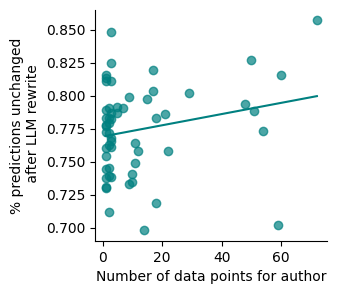

In [132]:
def show_the_effect_of_size_linear(changes_in_predictions_wassa):

    wassa_main_df = pd.read_csv("../datasets/wassa_individual/clean_wassa.csv")
    speaker_ids_value_counts = wassa_main_df["speaker_id"].value_counts()
    speaker_ids_to_num_datapoints = dict(
        zip(
            [str(x) for x in speaker_ids_value_counts.index.tolist()],
            speaker_ids_value_counts.values.tolist(),
        )
    )

    df_to_work_on = changes_in_predictions_wassa.copy()

    df_to_work_on["unchanged"] = (
        df_to_work_on["unchanged"] / df_to_work_on["occurrences"]
    )
    df_to_work_on["higher"] = df_to_work_on["higher"] / df_to_work_on["occurrences"]
    df_to_work_on["lower"] = df_to_work_on["lower"] / df_to_work_on["occurrences"]
    df_to_work_on.drop(columns=["occurrences"], inplace=True)
    df_to_work_on = (
        df_to_work_on.groupby(["speaker_id"])[["unchanged", "higher", "lower"]]
        .mean()
        .reset_index()
    )
    df_to_work_on["num_points"] = df_to_work_on["speaker_id"].map(
        speaker_ids_to_num_datapoints
    )
    # df_to_work_on = df_to_work_on[df_to_work_on["num_points"] > 4]
    # sub_df = df_to_work_on[df_to_work_on["LLM_model"] == llm_model].copy()
    sub_df = df_to_work_on.copy()

    x = sub_df["num_points"]
    condition_to_select = "unchanged"
    y = sub_df[condition_to_select]

    fig, ax = plt.subplots(figsize=(3, 3))
    plt.scatter(x, y, color="teal", alpha=0.7)
    # also the trendline
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="teal")

    correlation = np.corrcoef(x, y)[0, 1]
    p_value = stats.pearsonr(x, y)[1]
    degree_of_freedom = len(x) - 2

    print(correlation, p_value, degree_of_freedom)

    # plt.text(
    #     10,
    #     0.7,
    #     f"r ({degree_of_freedom})= {correlation:.2f}; p= {p_value:.2f}",
    #     fontsize=12,
    #     ha="left",
    # )

    plt.xlabel("Number of data points for author")
    plt.ylabel(f"% predictions {condition_to_select}\n after LLM rewrite")

    # drop the right and top spines
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    plt.savefig(
        f"figures/size_effect_linear_{condition_to_select}.png",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()


show_the_effect_of_size_linear(changes_in_predictions_wassa)